Dataset: https://www.kaggle.com/datasets/thedevastator/cancer-patients-and-air-pollution-a-new-link

# **Goal:**

* predicting the likelihood of a patient developing lung cancer
* identifying risk factors for lung cancer
* determining the most effective treatment for a patient with lung cancer


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')
sns.set_style("whitegrid")

In [3]:
# After uploading, read the CSV file
df = pd.read_csv('lung_cancer.csv')  # Replace with your actual filename

# Display basic information
print("Dataset Shape:", df.shape)
print("\nData Info:")
print(df.info())
print(df.columns)

Dataset Shape: (1000, 26)

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   index                     1000 non-null   int64 
 1   Patient Id                1000 non-null   object
 2   Age                       1000 non-null   int64 
 3   Gender                    1000 non-null   int64 
 4   Air Pollution             1000 non-null   int64 
 5   Alcohol use               1000 non-null   int64 
 6   Dust Allergy              1000 non-null   int64 
 7   OccuPational Hazards      1000 non-null   int64 
 8   Genetic Risk              1000 non-null   int64 
 9   chronic Lung Disease      1000 non-null   int64 
 10  Balanced Diet             1000 non-null   int64 
 11  Obesity                   1000 non-null   int64 
 12  Smoking                   1000 non-null   int64 
 13  Passive Smoker            1000 non-null  

In [4]:
df.head()

index Patient Id  Age  Gender  Air Pollution  Alcohol use  Dust Allergy  \
0      0         P1   33       1              2            4             5   
1      1        P10   17       1              3            1             5   
2      2       P100   35       1              4            5             6   
3      3      P1000   37       1              7            7             7   
4      4       P101   46       1              6            8             7   

   OccuPational Hazards  Genetic Risk  chronic Lung Disease  Balanced Diet  \
0                     4             3                     2              2   
1                     3             4                     2              2   
2                     5             5                     4              6   
3                     7             6                     7              7   
4                     7             7                     6              7   

   Obesity  Smoking  Passive Smoker  Chest Pain  Coughing of Blood  Fatigue  \
0        4        3               2           2                  4        3   
1        2        2               4           2                  3        1   
2        7        2               3           4                  8        8   
3        7        7               7           7                  8        4   
4        7        8               7           7                  9        3   

   Weight Loss  Shortness of Breath  Wheezing  Swallowing Difficulty  \
0            4                    2         2                      3   
1            3                    7         8                      6   
2            7                    9         2                      1   
3            2                    3         1                      4   
4            2                    4         1                      4   

   Clubbing of Finger Nails  Frequent Cold  Dry Cough  Snoring   Level  
0                         1              2          3        4     Low  
1                         2              1          7        2  Medium  
2                         4              6          7        2    High  
3                         5              6          7        5    High  
4                         2              4          2        3    High

In [5]:
# Convert 'Level' to numeric
level_map = {'Low': 0, 'Medium': 1, 'High': 2}
df['Level'] = df['Level'].map(level_map)

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Display basic statistics
print("\nBasic Statistics:")
print(df.describe())


Missing Values:
index                       0
Patient Id                  0
Age                         0
Gender                      0
Air Pollution               0
Alcohol use                 0
Dust Allergy                0
OccuPational Hazards        0
Genetic Risk                0
chronic Lung Disease        0
Balanced Diet               0
Obesity                     0
Smoking                     0
Passive Smoker              0
Chest Pain                  0
Coughing of Blood           0
Fatigue                     0
Weight Loss                 0
Shortness of Breath         0
Wheezing                    0
Swallowing Difficulty       0
Clubbing of Finger Nails    0
Frequent Cold               0
Dry Cough                   0
Snoring                     0
Level                       0
dtype: int64

Basic Statistics:
             index          Age       Gender  Air Pollution  Alcohol use  \
count  1000.000000  1000.000000  1000.000000      1000.0000  1000.000000   
mean    499.500000 

In [6]:
# Drop 'index' and 'Patient Id' columns
data = df.drop(['index', 'Patient Id'], axis=1)

# Display the new set of columns to confirm
print("Updated columns:", data.columns)


Updated columns: Index(['Age', 'Gender', 'Air Pollution', 'Alcohol use', 'Dust Allergy',
       'OccuPational Hazards', 'Genetic Risk', 'chronic Lung Disease',
       'Balanced Diet', 'Obesity', 'Smoking', 'Passive Smoker', 'Chest Pain',
       'Coughing of Blood', 'Fatigue', 'Weight Loss', 'Shortness of Breath',
       'Wheezing', 'Swallowing Difficulty', 'Clubbing of Finger Nails',
       'Frequent Cold', 'Dry Cough', 'Snoring', 'Level'],
      dtype='object')


# **Feature Distribution**

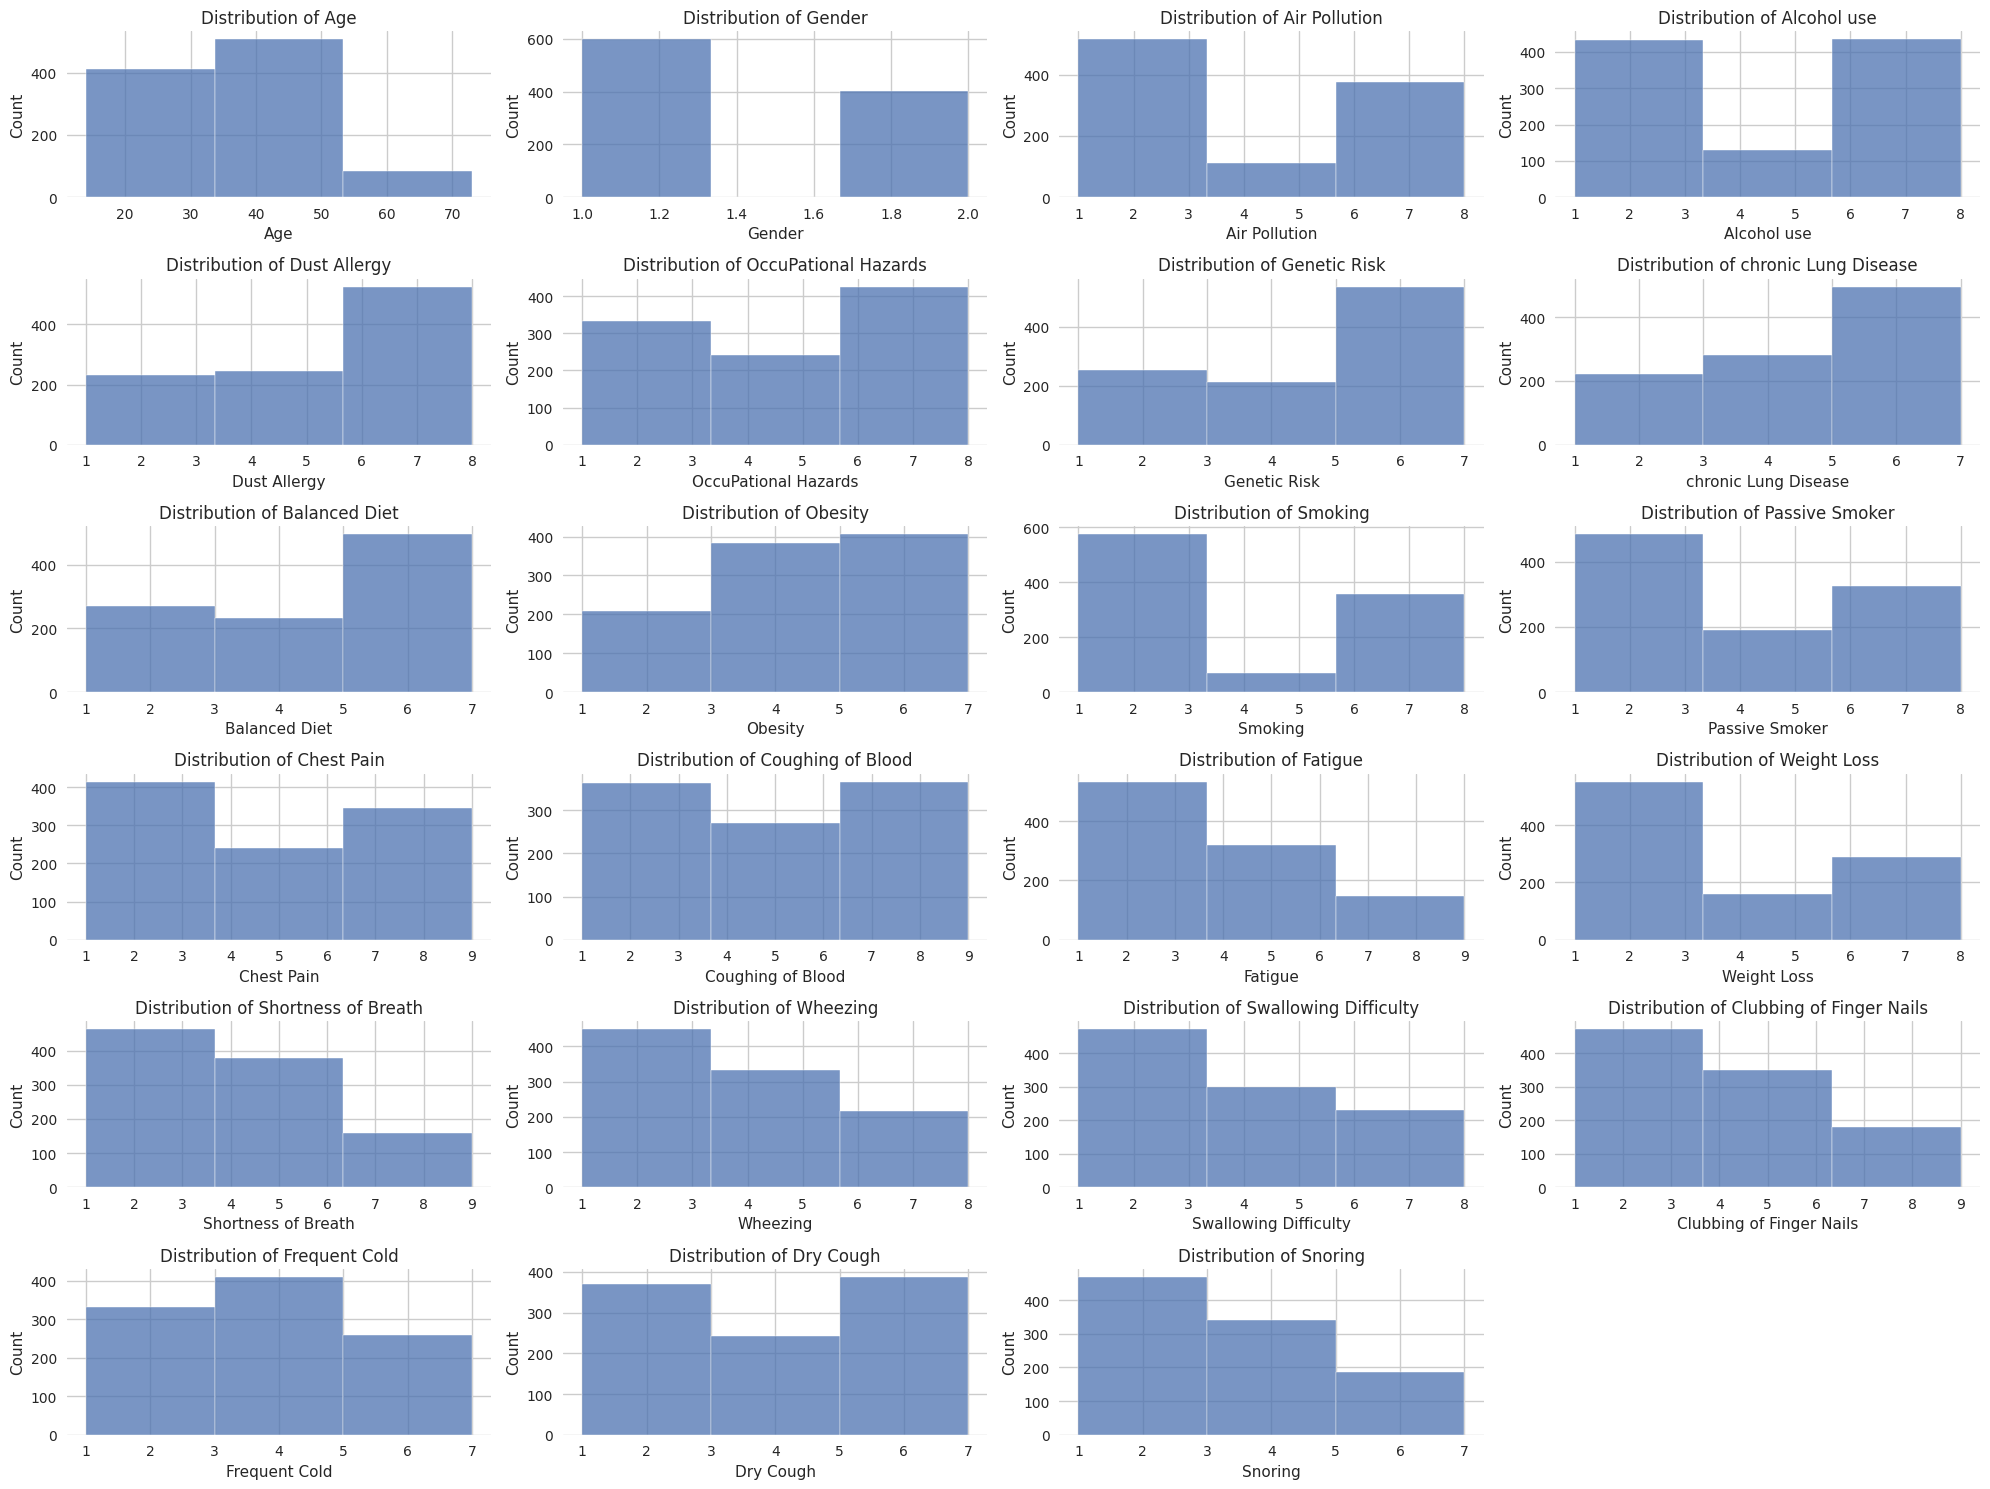

In [7]:
plt.figure(figsize=(20, 15))
# Adjust the subplot grid to accommodate all columns
num_cols = len(data.columns[:-1])
num_rows = (num_cols + 3) // 4  # Calculate rows needed, ensuring at least 1

for i, col in enumerate(data.columns[:-1], 1):
    plt.subplot(num_rows, 4, i)  # Use calculated rows
    sns.histplot(data=data, x=col, bins=3)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


# **Correlation Matrix**

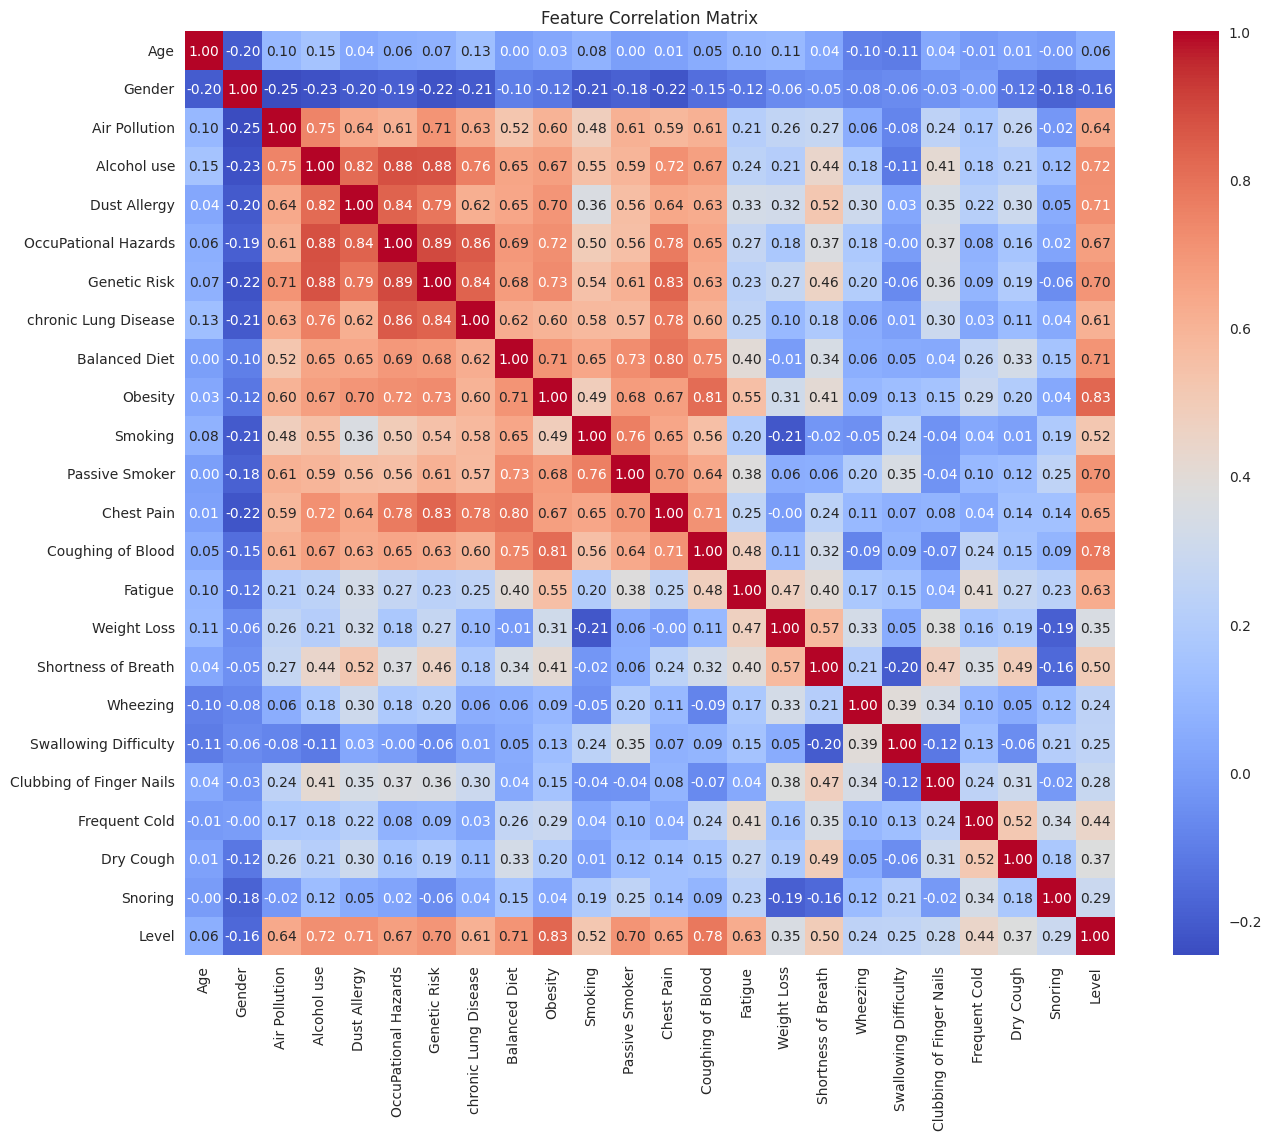

In [8]:
plt.figure(figsize=(15, 12))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()


# **Dendrogram**

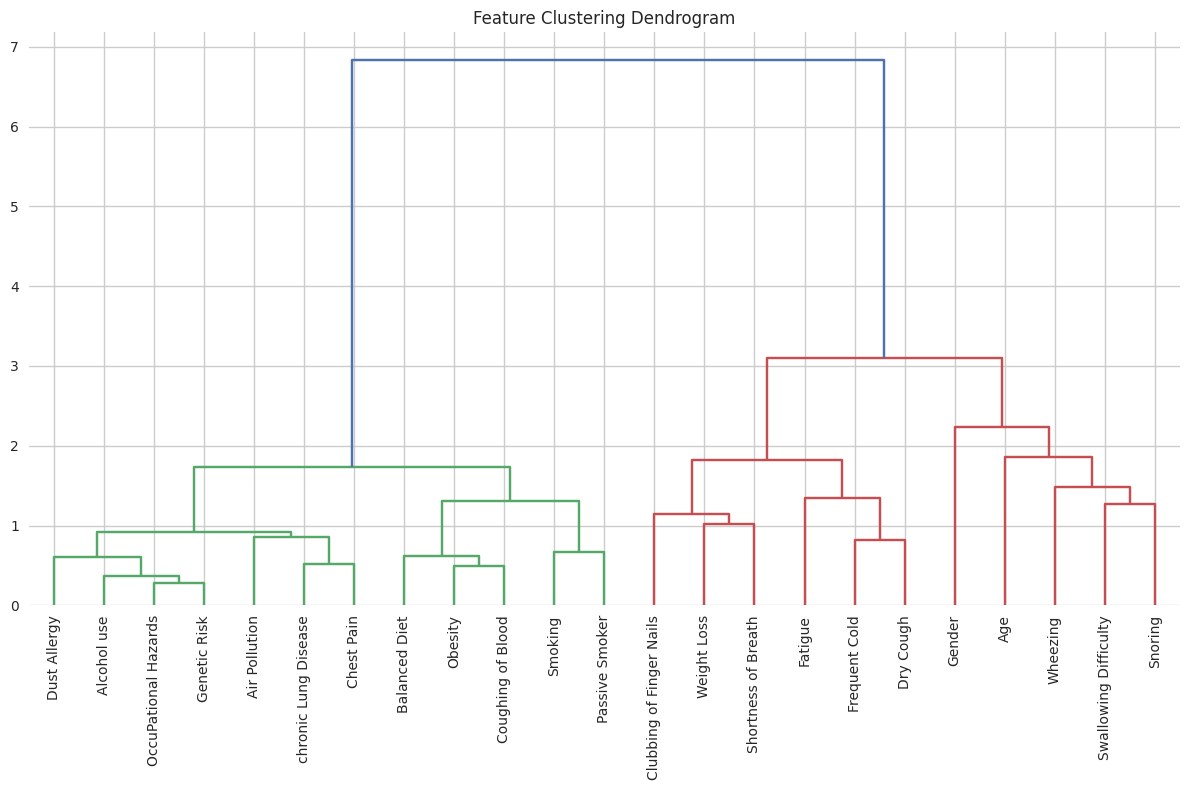

In [9]:
plt.figure(figsize=(12, 8))
linkage_matrix = hierarchy.linkage(data.iloc[:, :-1].corr(), method='ward')
dendrogram_labels = data.columns[:-1]
hierarchy.dendrogram(linkage_matrix, labels=dendrogram_labels, leaf_rotation=90)
plt.title('Feature Clustering Dendrogram')
plt.tight_layout()
plt.show()

# **Outlier Detection**


Performing Outlier Analysis...


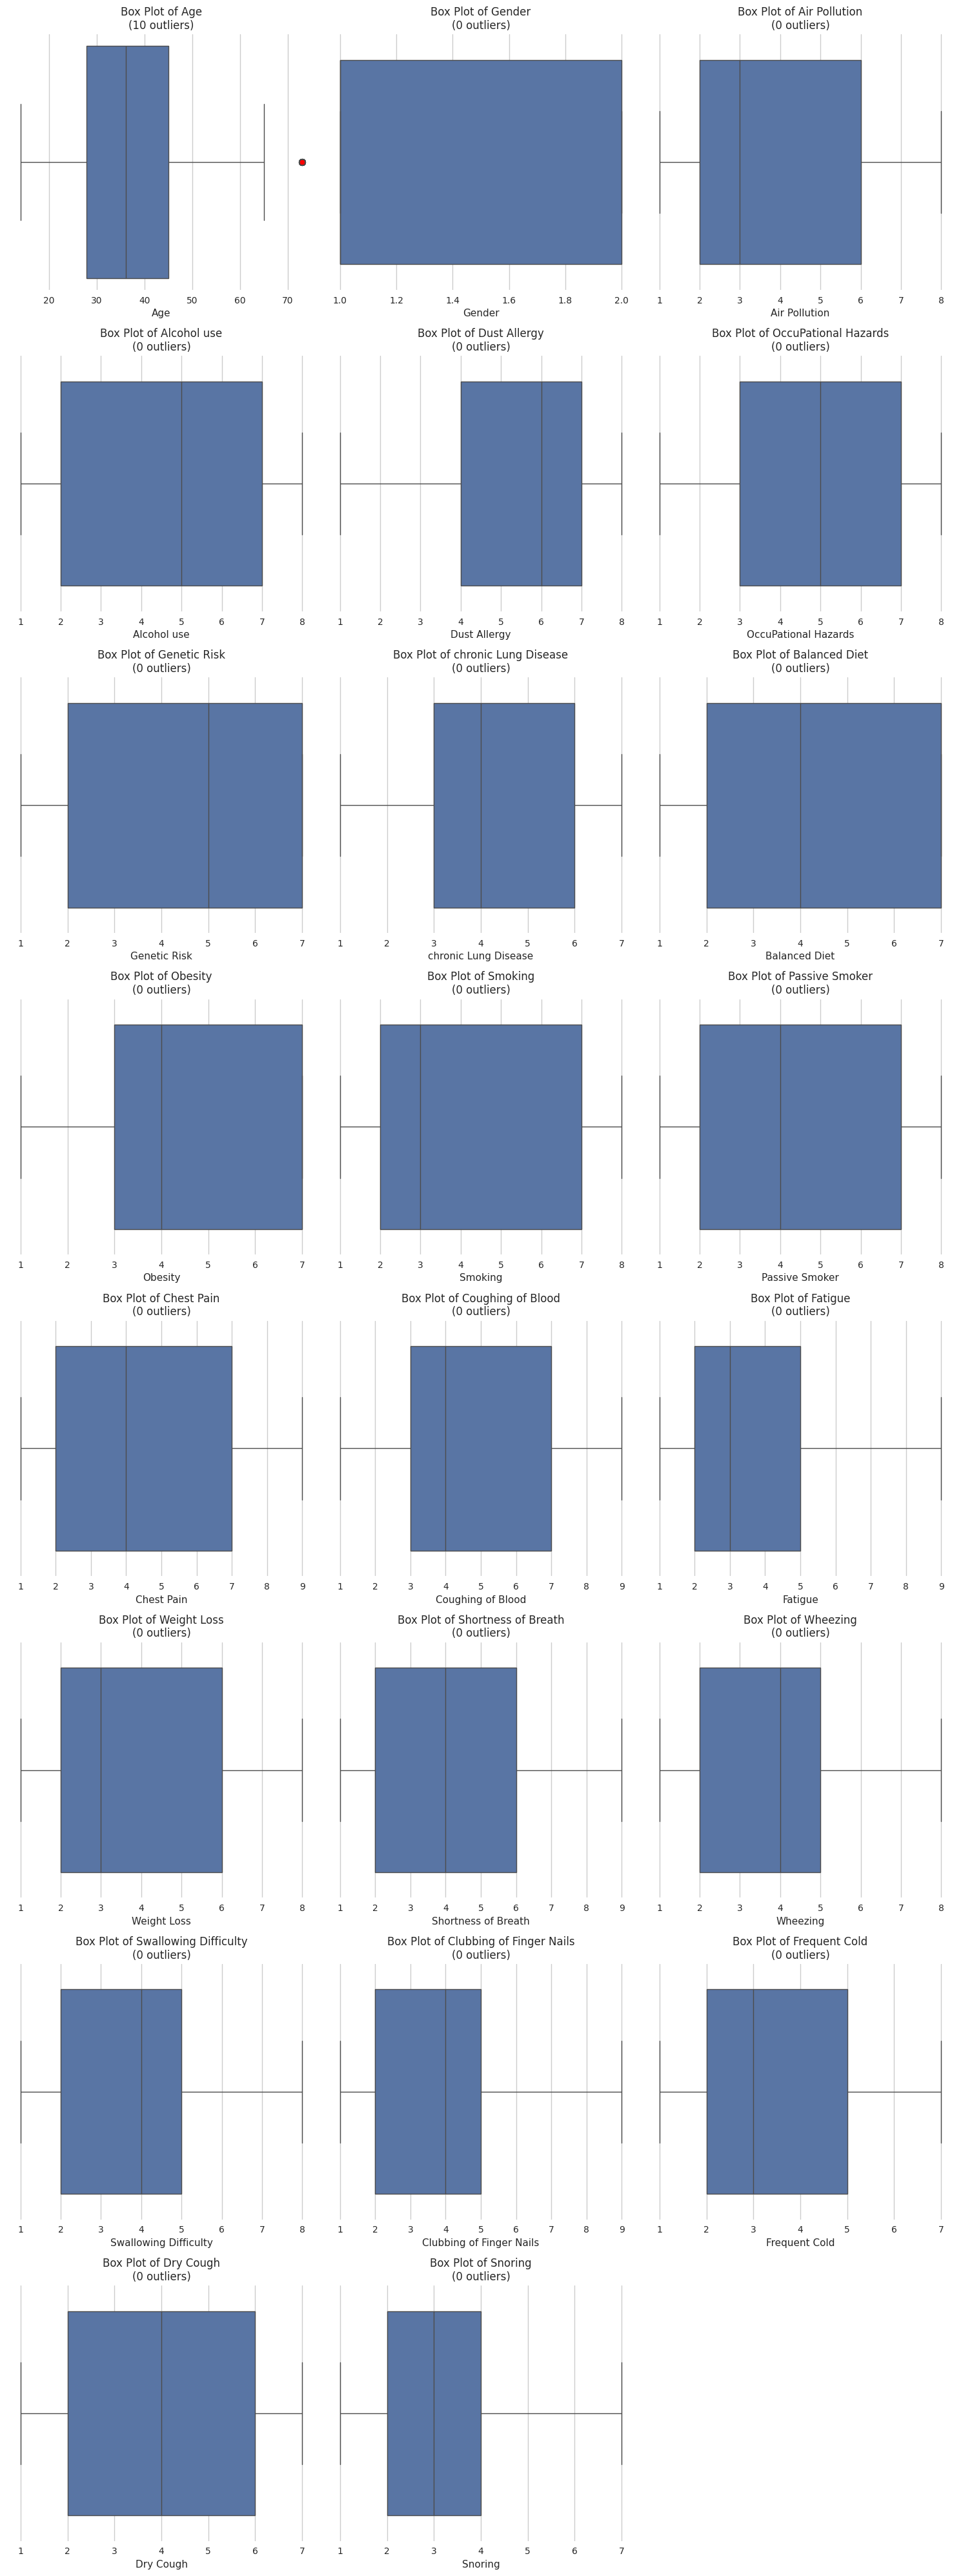


Outlier Summary:
Age: 10 outliers detected
Outlier values: [73, 73, 73, 73, 73, 73, 73, 73, 73, 73]


Total number of rows with at least one outlier: 10


In [10]:
# Cell 3.5: Outlier Detection and Visualization
def detect_and_plot_outliers(df, numeric_columns):
    """
    Detect outliers using IQR method and create box plots for visualization.

    Parameters:
    df (pandas.DataFrame): Input DataFrame
    numeric_columns (list): List of numeric column names to analyze

    Returns:
    dict: Dictionary containing outlier indices for each column
    """
    outliers_dict = {}

    # Create a figure for box plots
    n_cols = 3
    n_rows = (len(numeric_columns) + n_cols - 1) // n_cols
    fig = plt.figure(figsize=(15, 5 * n_rows))

    for idx, column in enumerate(numeric_columns, 1):
        # Calculate Q1, Q3, and IQR
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Define outlier boundaries
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Find outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
        outliers_dict[column] = outliers.index.tolist()

        # Create subplot
        plt.subplot(n_rows, n_cols, idx)

        # Create box plot
        sns.boxplot(x=df[column])

        # Add scatter points for outliers
        if len(outliers) > 0:
            plt.scatter(outliers, [0] * len(outliers),
                       color='red', label='Outliers', alpha=0.5)

        plt.title(f'Box Plot of {column}\n({len(outliers)} outliers)')
        plt.xlabel(column)

    plt.tight_layout()
    plt.show()

    # Print summary of outliers
    print("\nOutlier Summary:")
    for column in numeric_columns:
        n_outliers = len(outliers_dict[column])
        if n_outliers > 0:
            print(f"{column}: {n_outliers} outliers detected")
            print(f"Outlier values: {df.loc[outliers_dict[column], column].tolist()}\n")

    return outliers_dict

# Add this after the missing values check in Cell 3
numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()
if 'Level' in numeric_columns:  # Remove target variable if it's numeric
    numeric_columns.remove('Level')

print("\nPerforming Outlier Analysis...")
outliers = detect_and_plot_outliers(data, numeric_columns)

# Optional: Add code to handle outliers
print("\nTotal number of rows with at least one outlier:",
      len(set().union(*outliers.values())))

# You can choose to remove outliers if needed:
# df_no_outliers = df.copy()
# all_outlier_indices = set().union(*outliers.values())
# df_no_outliers = df_no_outliers.drop(index=all_outlier_indices)
# print(f"\nRows after removing outliers: {len(df_no_outliers)}")

# **Data Preparation**

In [11]:
X = data.iloc[:, :-1]
y = data['Level']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# **Model Training**


Training SVM...


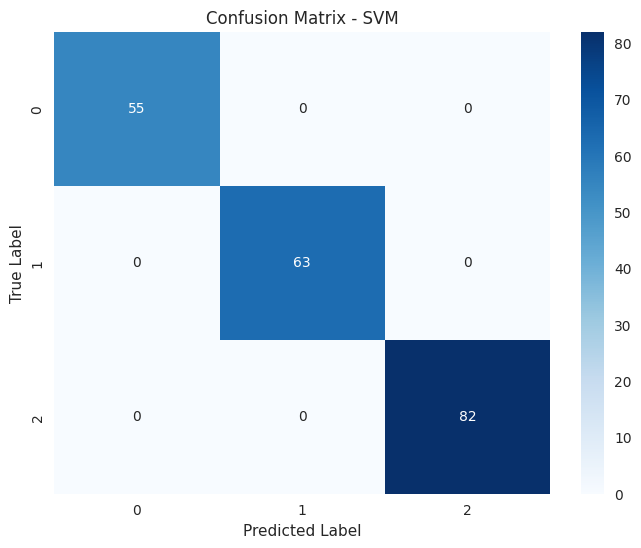


Metrics for SVM:
R2 Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        55
           1       1.00      1.00      1.00        63
           2       1.00      1.00      1.00        82

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200


Training KNN...


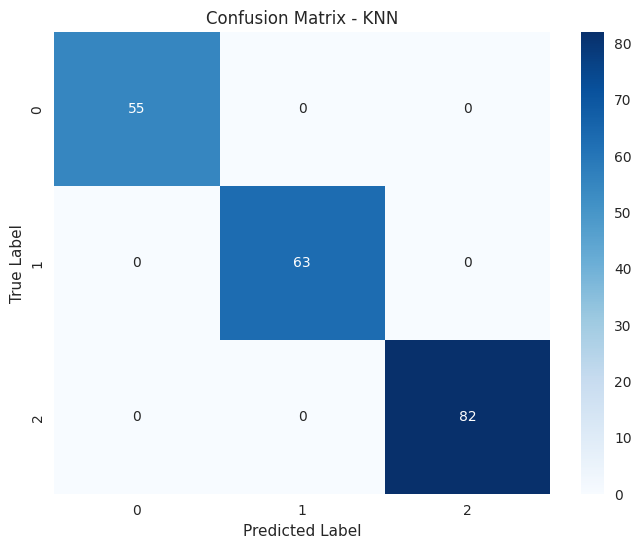


Metrics for KNN:
R2 Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        55
           1       1.00      1.00      1.00        63
           2       1.00      1.00      1.00        82

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200


Training Decision Tree...


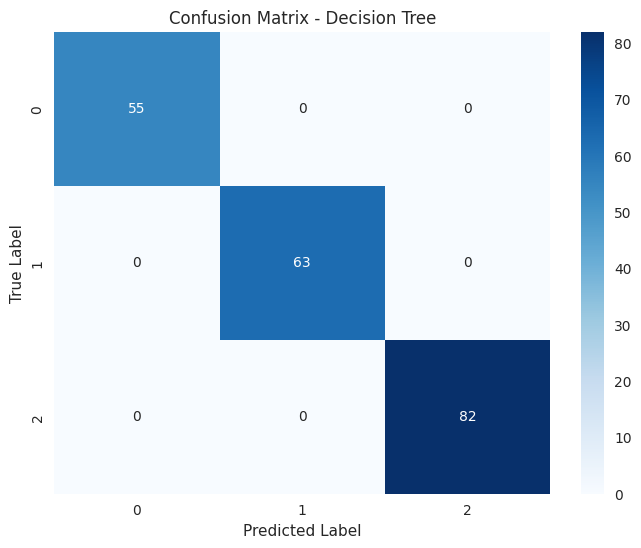


Metrics for Decision Tree:
R2 Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        55
           1       1.00      1.00      1.00        63
           2       1.00      1.00      1.00        82

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



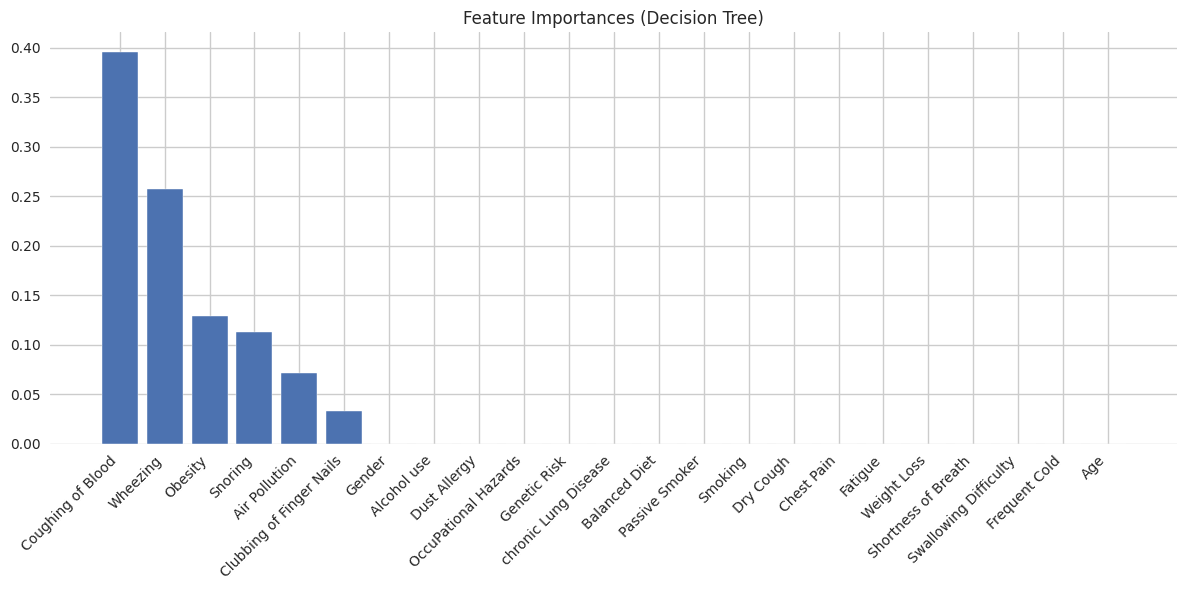


Training Random Forest...


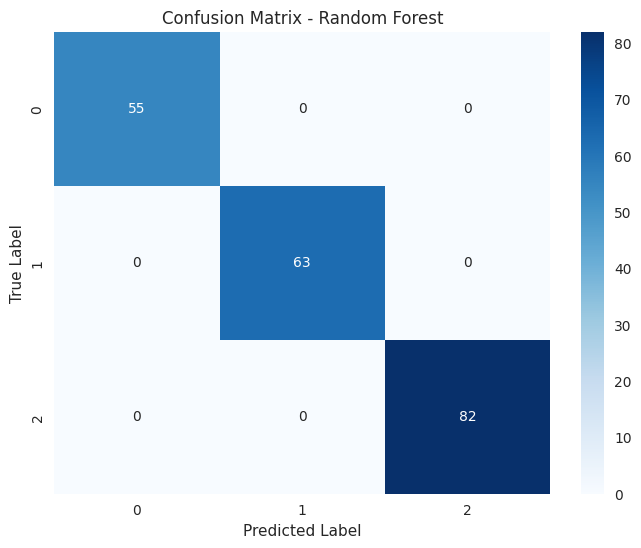


Metrics for Random Forest:
R2 Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        55
           1       1.00      1.00      1.00        63
           2       1.00      1.00      1.00        82

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



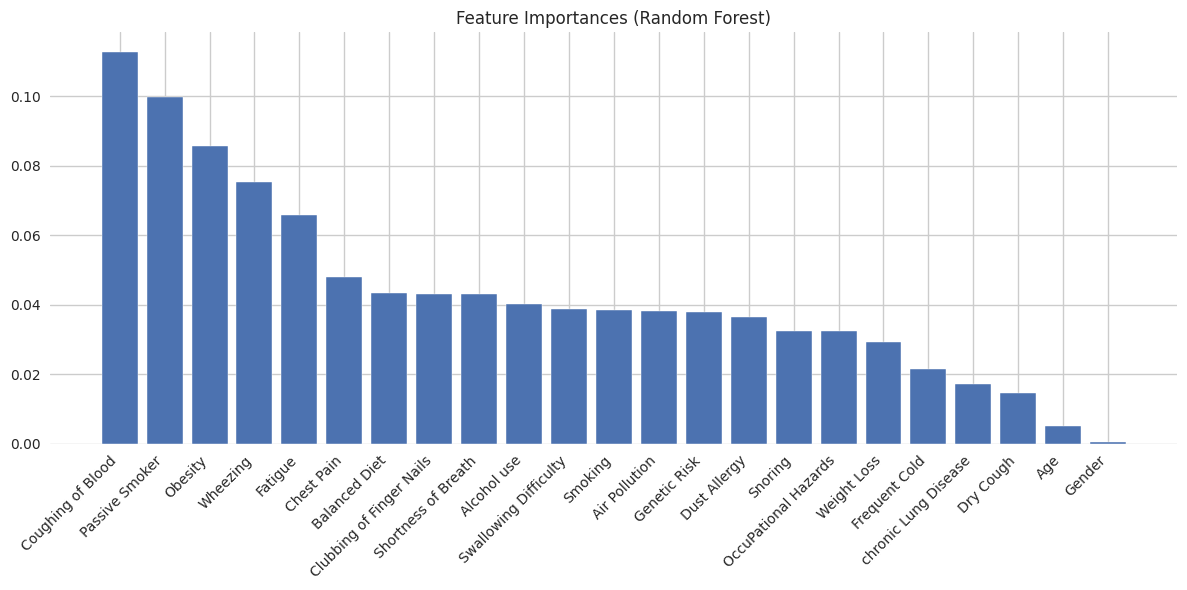

In [12]:
models = {
    'SVM': SVC(kernel='rbf', probability=True),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")

    # Fit model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    # Calculate metrics
    #mse = mean_squared_error(y_test, y_pred)
    #rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Print metrics
    print(f"\nMetrics for {name}:")
    #print(f"MSE: {mse:.4f}")
    #print(f"RMSE: {rmse:.4f}")
    print(f"R2 Score: {r2:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot feature importance for tree-based models
    if name in ['Decision Tree', 'Random Forest']:
        plt.figure(figsize=(12, 6))
        importance = model.feature_importances_
        indices = np.argsort(importance)[::-1]
        plt.title(f"Feature Importances ({name})")
        plt.bar(range(len(importance)), importance[indices])
        plt.xticks(range(len(importance)), [X.columns[i] for i in indices], rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(f"{name}_feature_importance.png")
        plt.show()

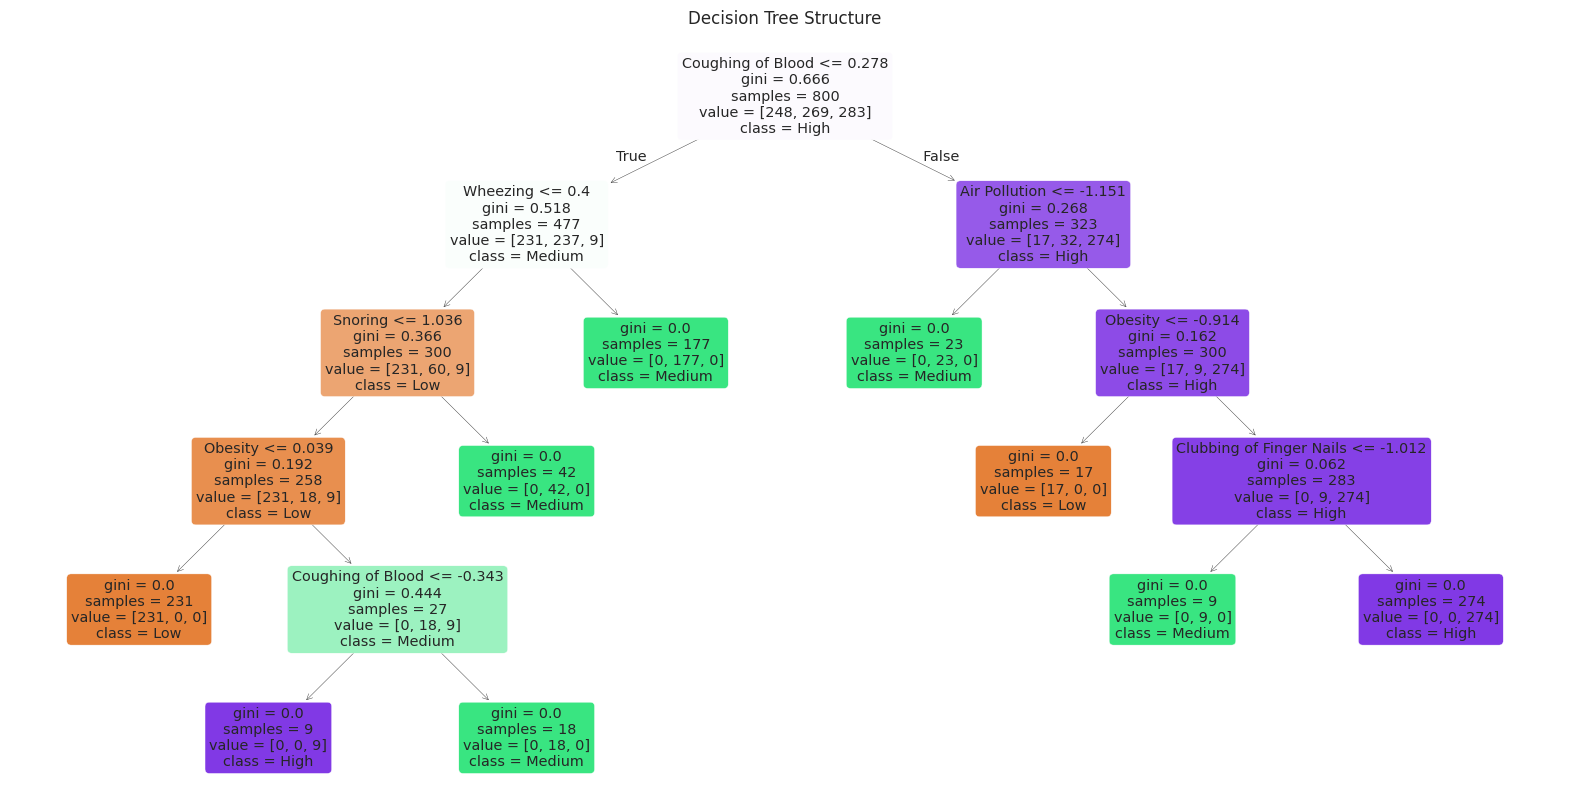

In [13]:
plt.figure(figsize=(20, 10))
tree_model = models['Decision Tree']
plot_tree(tree_model, feature_names=X.columns,
         class_names=['Low', 'Medium', 'High'], filled=True, rounded=True)
plt.title('Decision Tree Structure')
plt.savefig("decision_tree_structure.png")
plt.show()

# **Feature Importance Analysis**


Feature Importance:
                     feature  importance
13         Coughing of Blood    0.112728
11            Passive Smoker    0.099777
9                    Obesity    0.085630
17                  Wheezing    0.075292
14                   Fatigue    0.065887
12                Chest Pain    0.047938
8              Balanced Diet    0.043398
19  Clubbing of Finger Nails    0.043121
16       Shortness of Breath    0.043086
3                Alcohol use    0.040272
18     Swallowing Difficulty    0.038915
10                   Smoking    0.038630
2              Air Pollution    0.038229
6               Genetic Risk    0.037786
4               Dust Allergy    0.036367
22                   Snoring    0.032401
5       OccuPational Hazards    0.032379
15               Weight Loss    0.029377
20             Frequent Cold    0.021475
7       chronic Lung Disease    0.017274
21                 Dry Cough    0.014570
0                        Age    0.005093
1                     Gender    0.00

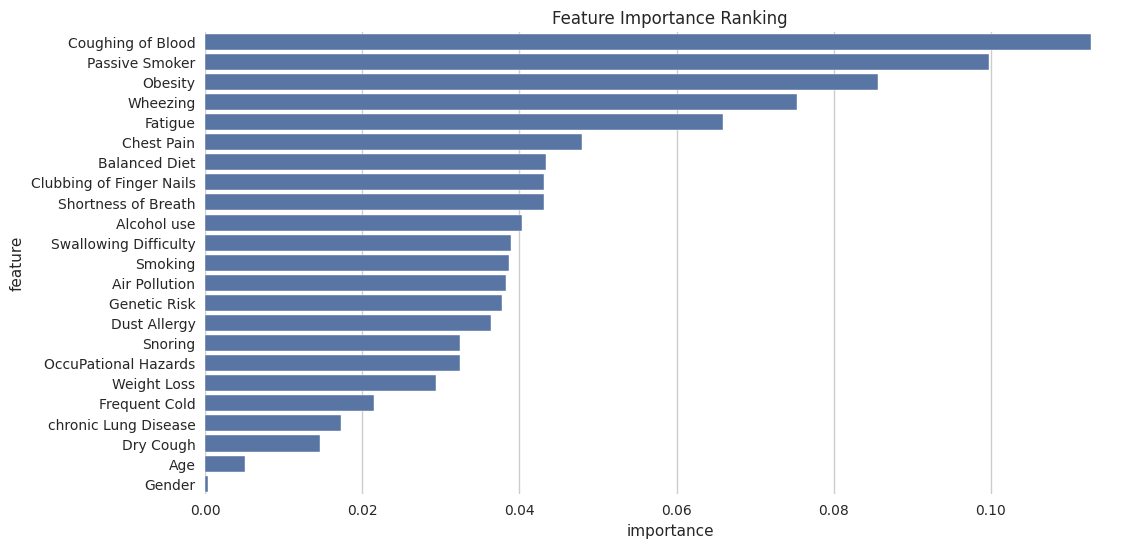

In [14]:
rf_model = models['Random Forest']
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance Ranking')
plt.show()

# **Learning Curve**

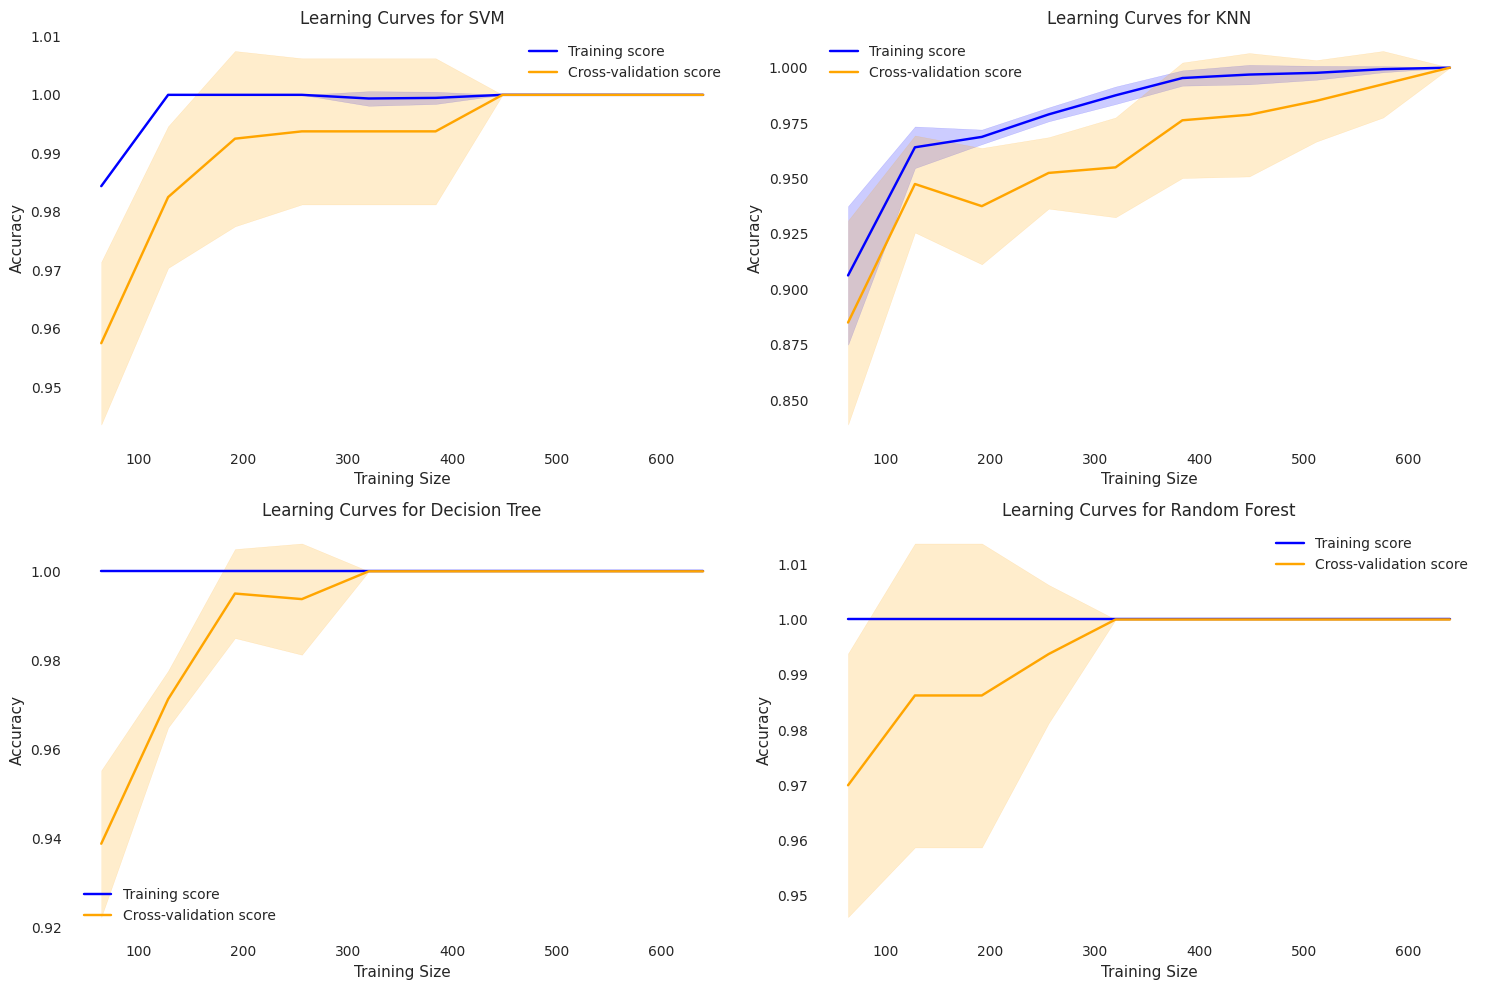

<Figure size 800x550 with 0 Axes>

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd


# Define a function to plot learning curves
def plot_learning_curves(models, X_data, y_data):
    # Added X_data and y_data as parameters to handle different data for each model
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

    i = 0  # Initialize a counter for the subplots
    for model_name, model in models.items():  # Iterate through the models dictionary

        # Determine the appropriate data to use based on model type
        X = X_data['scaled'] if model_name in ['SVM', 'KNN'] else X_data['original']
        y = y_data

        train_sizes, train_scores, test_scores = learning_curve(
            model, X, y, cv=5, n_jobs=-1,
            train_sizes=np.linspace(0.1, 1.0, 10),
            scoring='accuracy'
        )

        # Calculate mean and standard deviation for training and testing scores
        train_scores_mean = np.mean(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        # Plot learning curve
        axes[i].plot(train_sizes, train_scores_mean, label='Training score', color='blue')
        axes[i].plot(train_sizes, test_scores_mean, label='Cross-validation score', color='orange')

        # Plot the std deviation as a shaded region
        axes[i].fill_between(train_sizes, train_scores_mean - train_scores_std,
                             train_scores_mean + train_scores_std, color='blue', alpha=0.2)
        axes[i].fill_between(train_sizes, test_scores_mean - test_scores_std,
                             test_scores_mean + test_scores_std, color='orange', alpha=0.2)

        # Adding labels and title
        axes[i].set_title(f'Learning Curves for {model_name}')
        axes[i].set_xlabel('Training Size')
        axes[i].set_ylabel('Accuracy')
        axes[i].legend()
        axes[i].grid()

        i += 1  # Increment the counter for the next subplot

    plt.tight_layout()
    plt.show()


# Assuming your models dictionary is defined as you mentioned
models = {
    'SVM': SVC(kernel='rbf', probability=True),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

# Create a dictionary to store the data for each model type
X_data = {'scaled': X_train_scaled, 'original': X_train}
y_data = y_train

# Plot the learning curves using the loop
plot_learning_curves(models, X_data, y_data)
plt.savefig("learning_curve_2.png")

# **Risk Analysis and Treatment Prediction**

Analyzing feature impact on risk levels...

Analyzing SVM predictions...


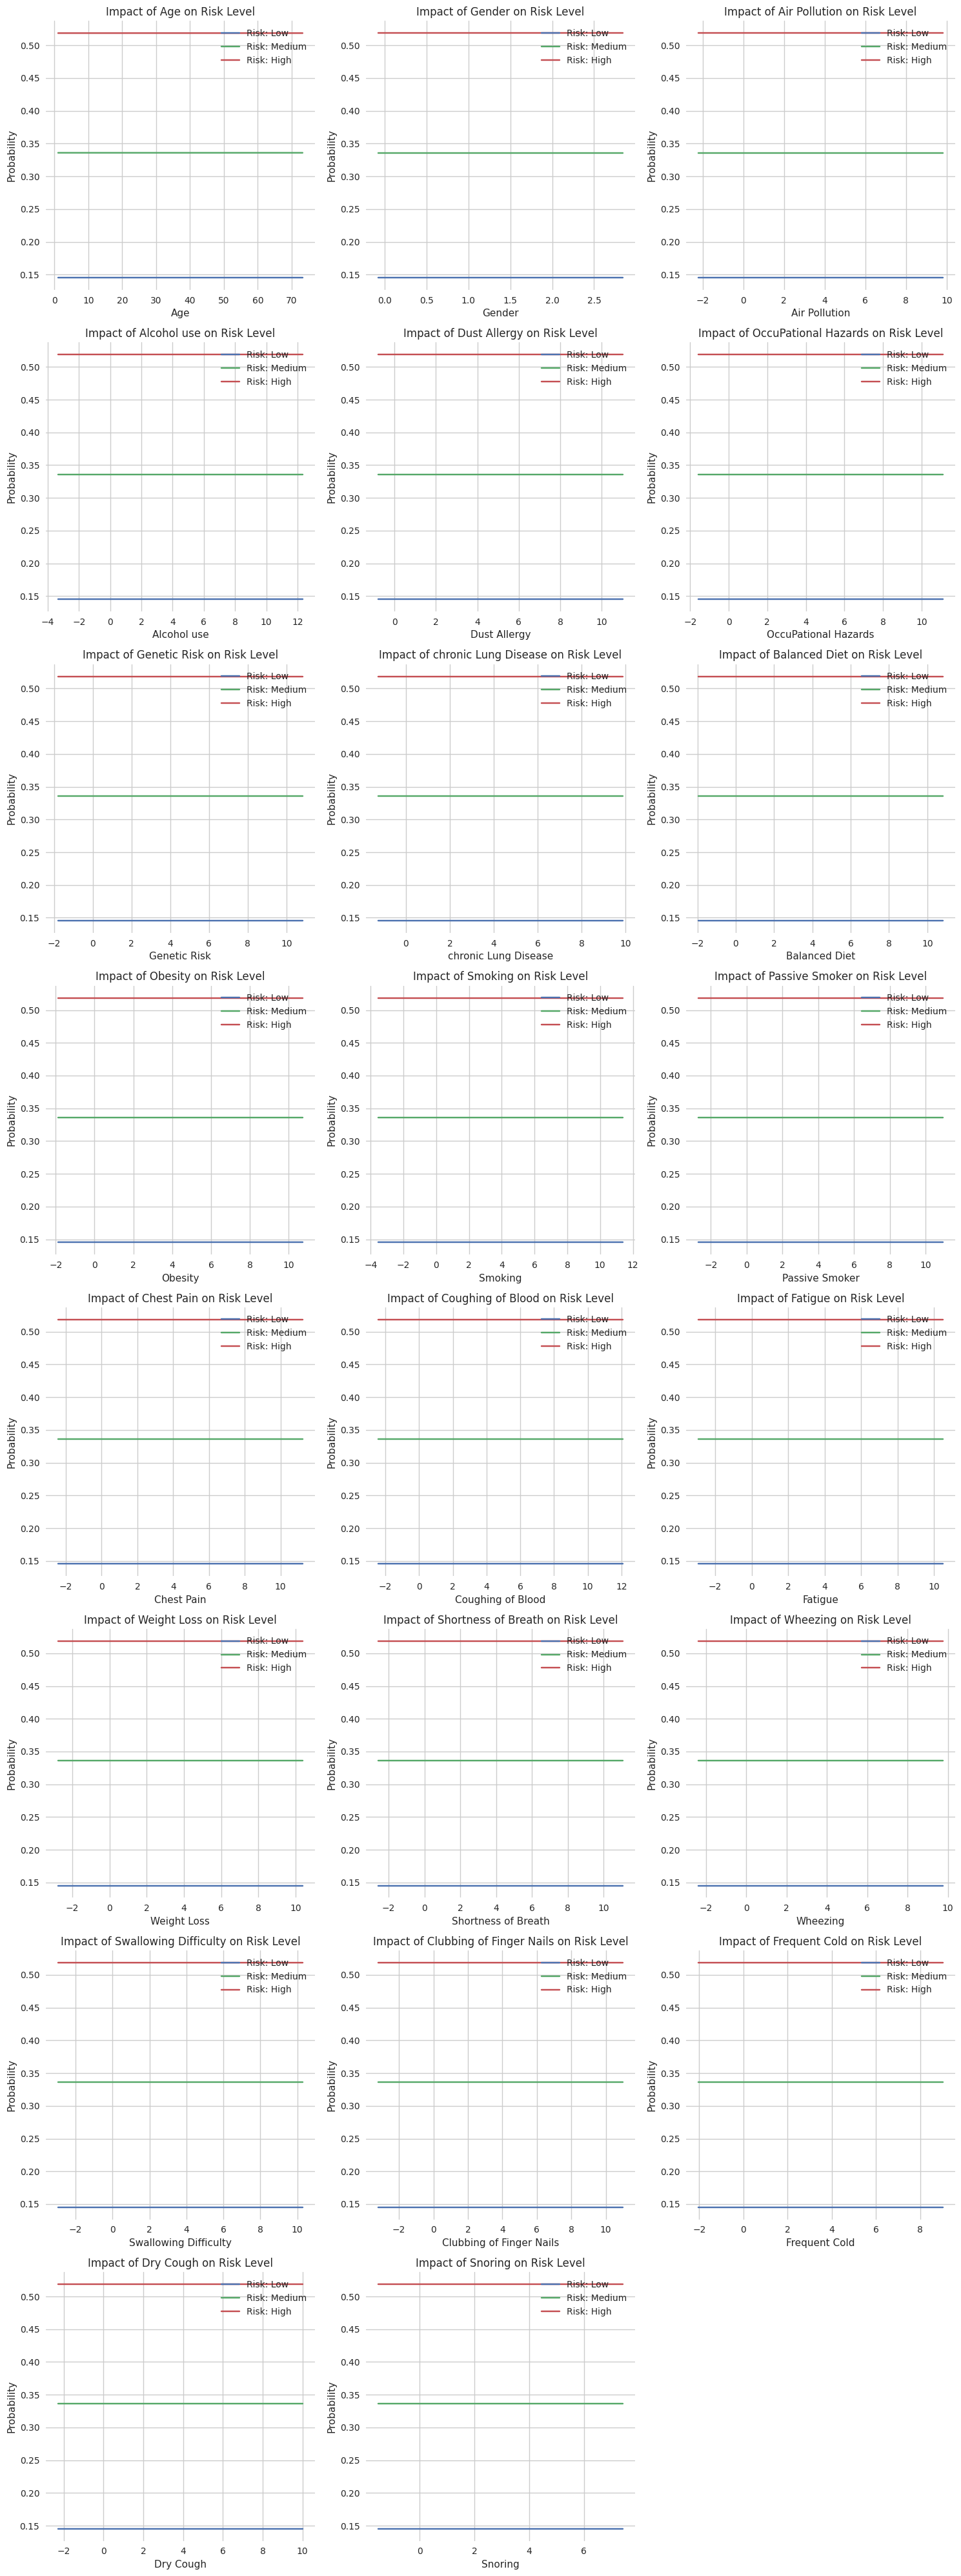


Analyzing KNN predictions...


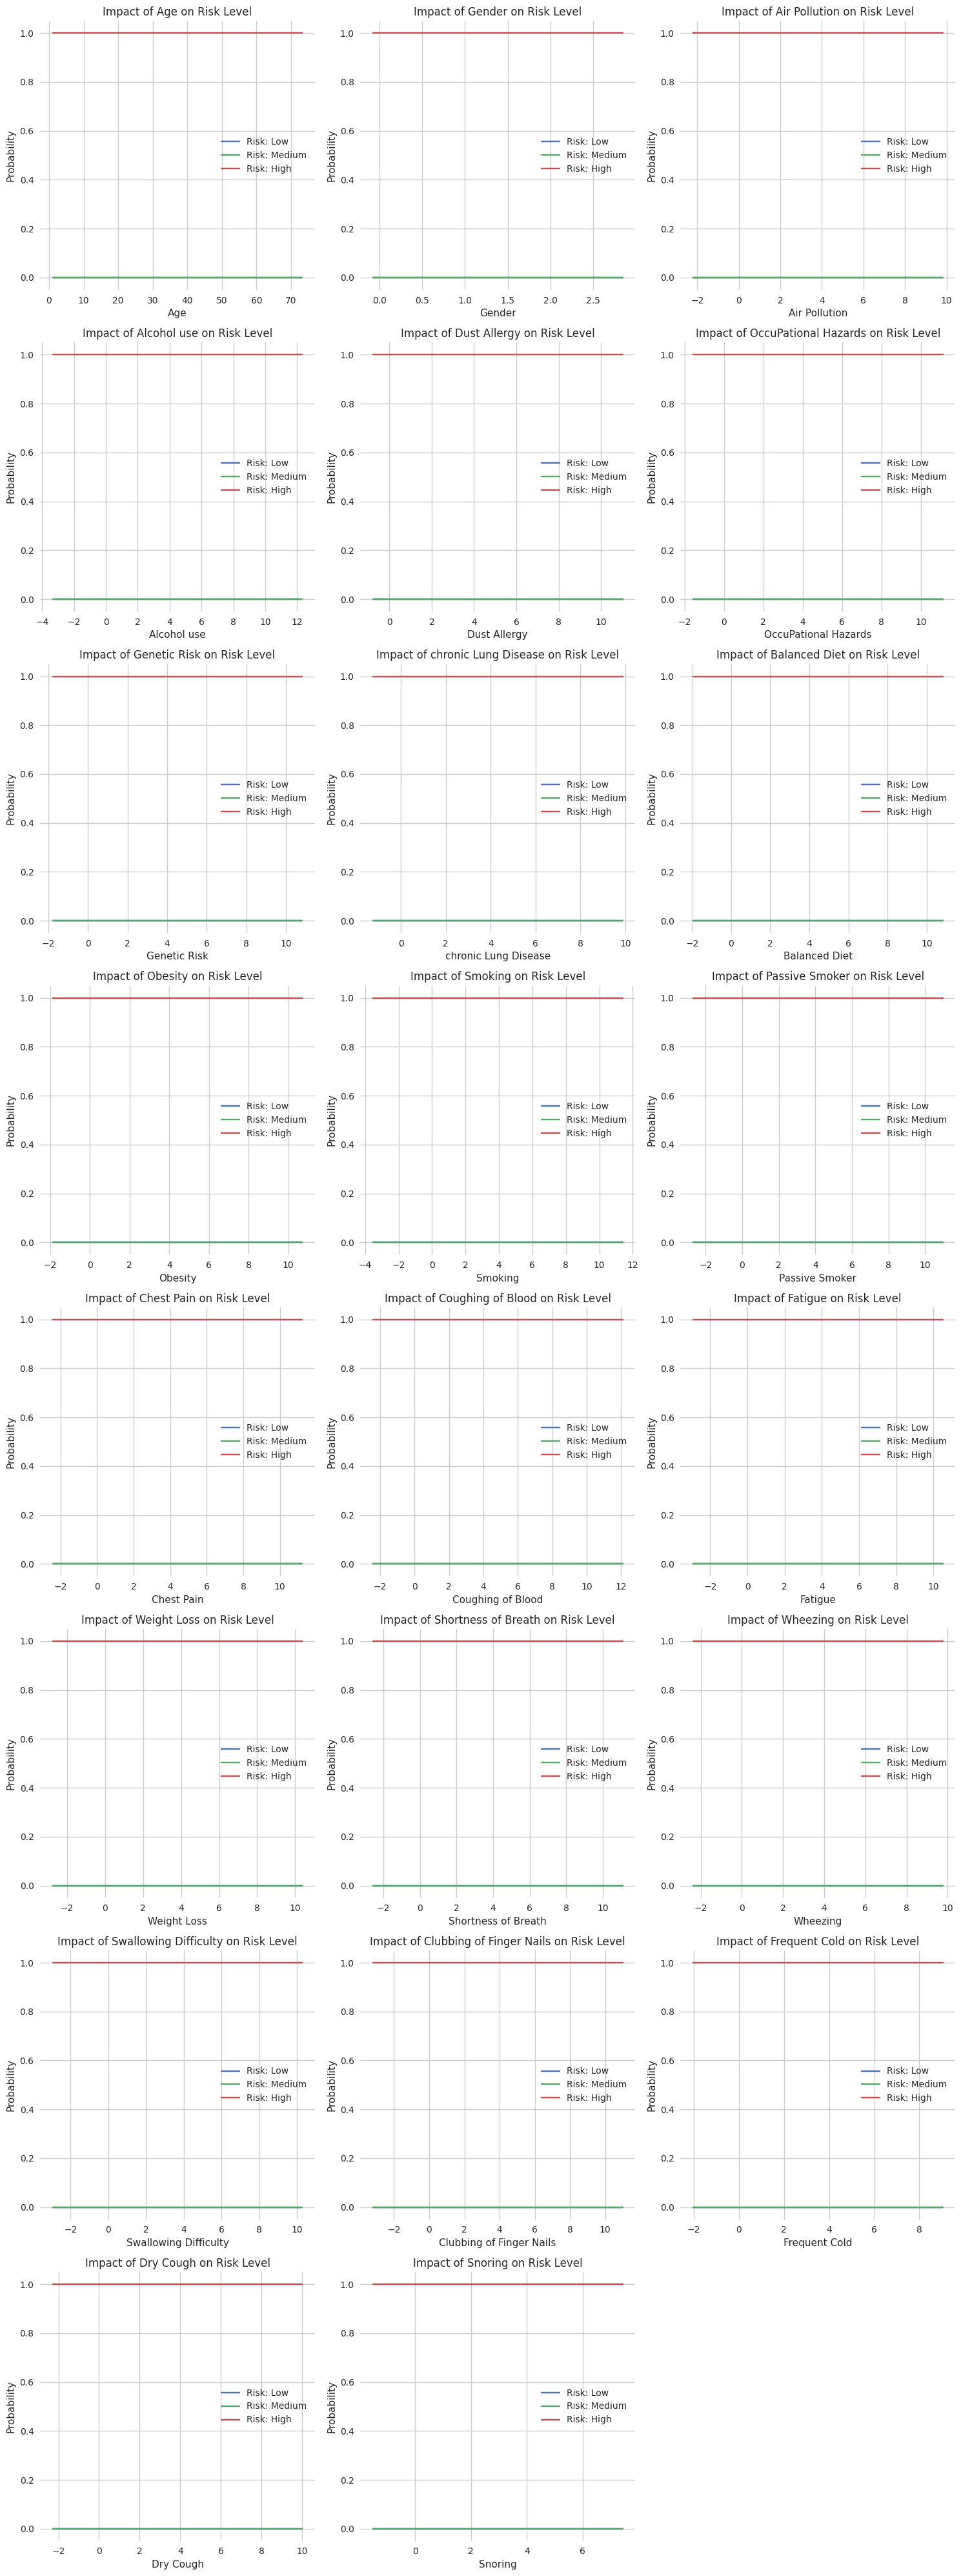


Analyzing Decision Tree predictions...


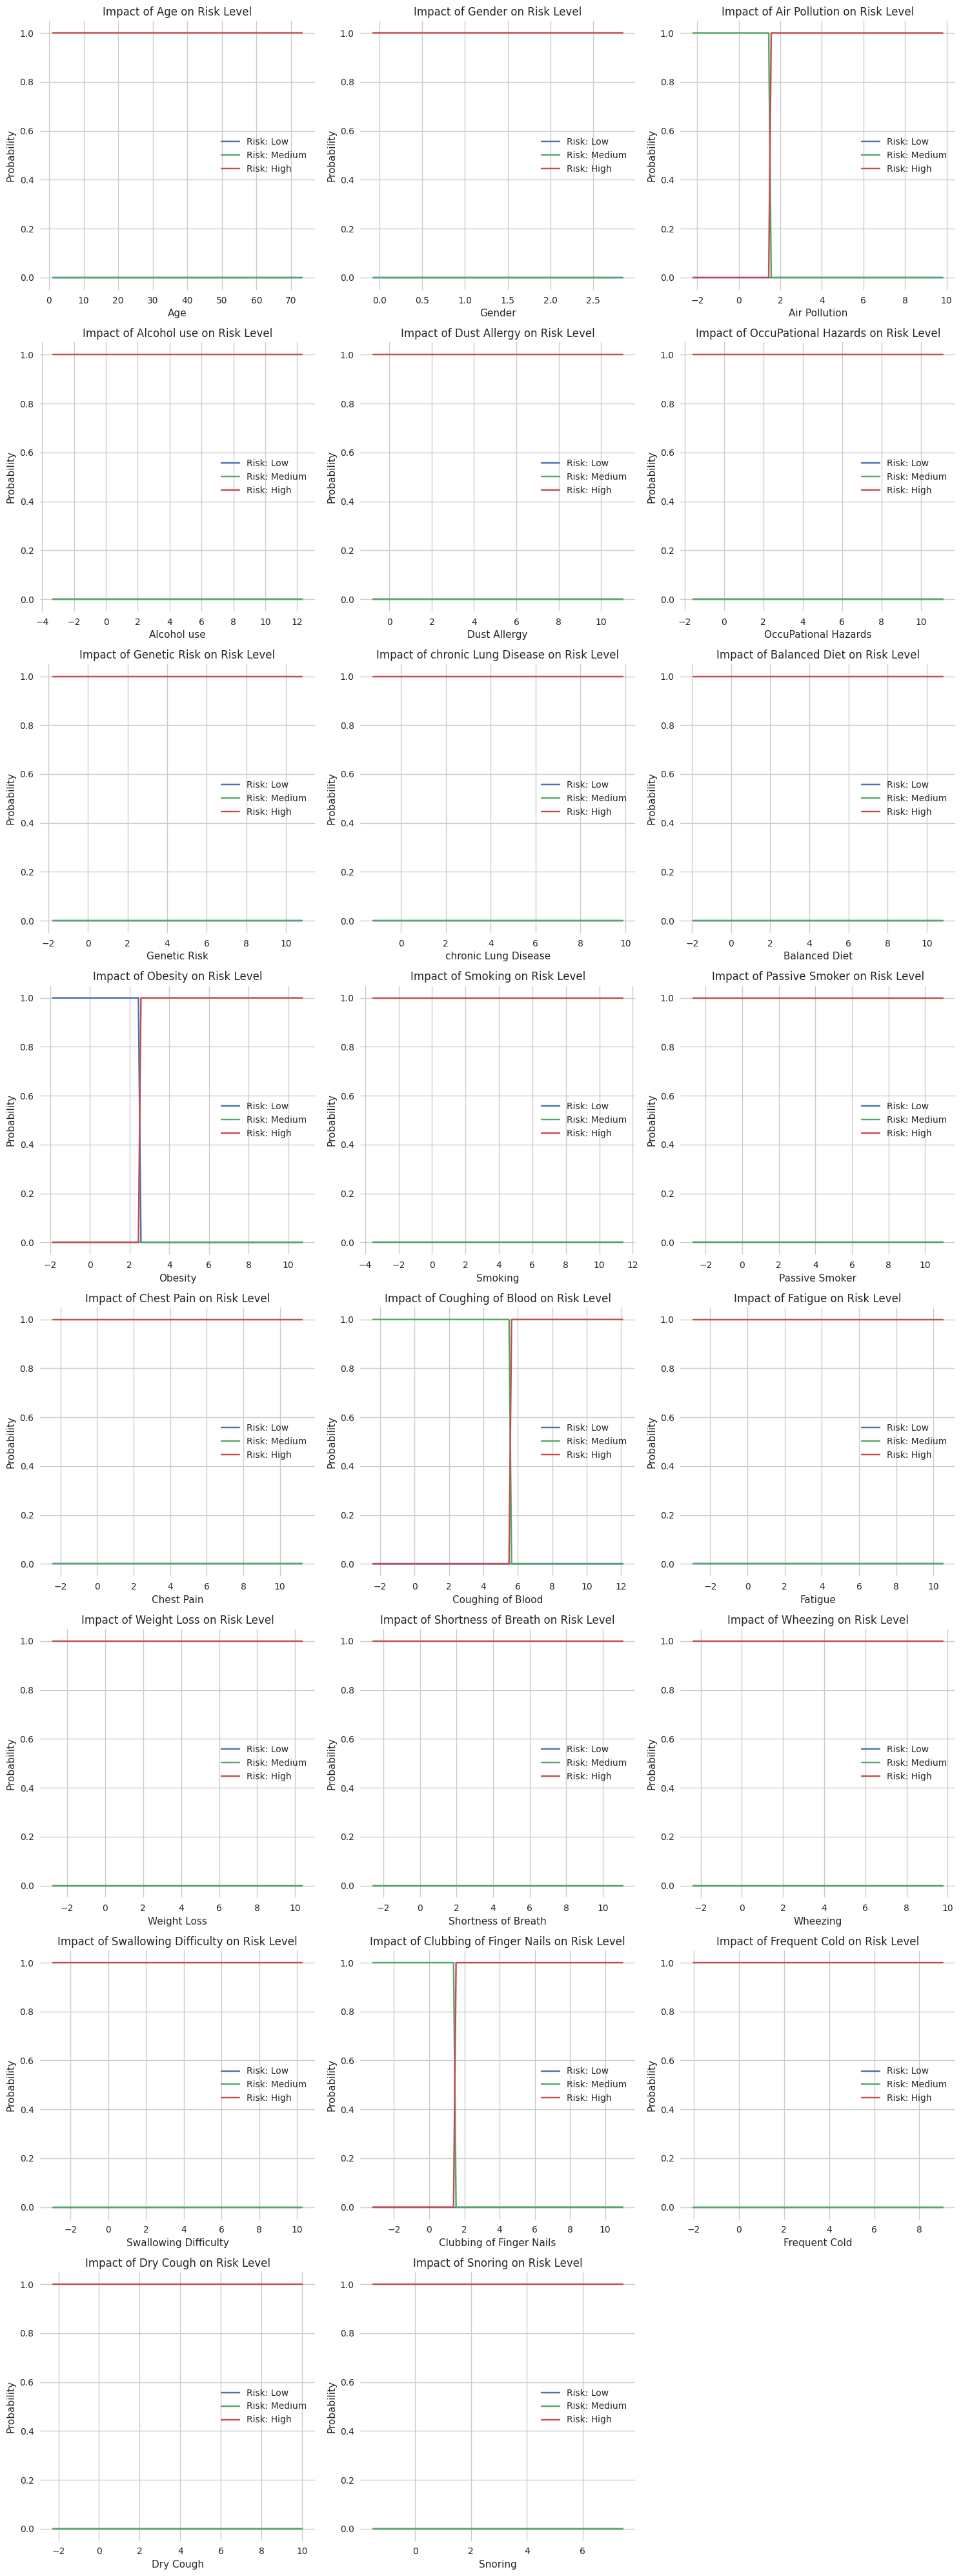


Analyzing Random Forest predictions...


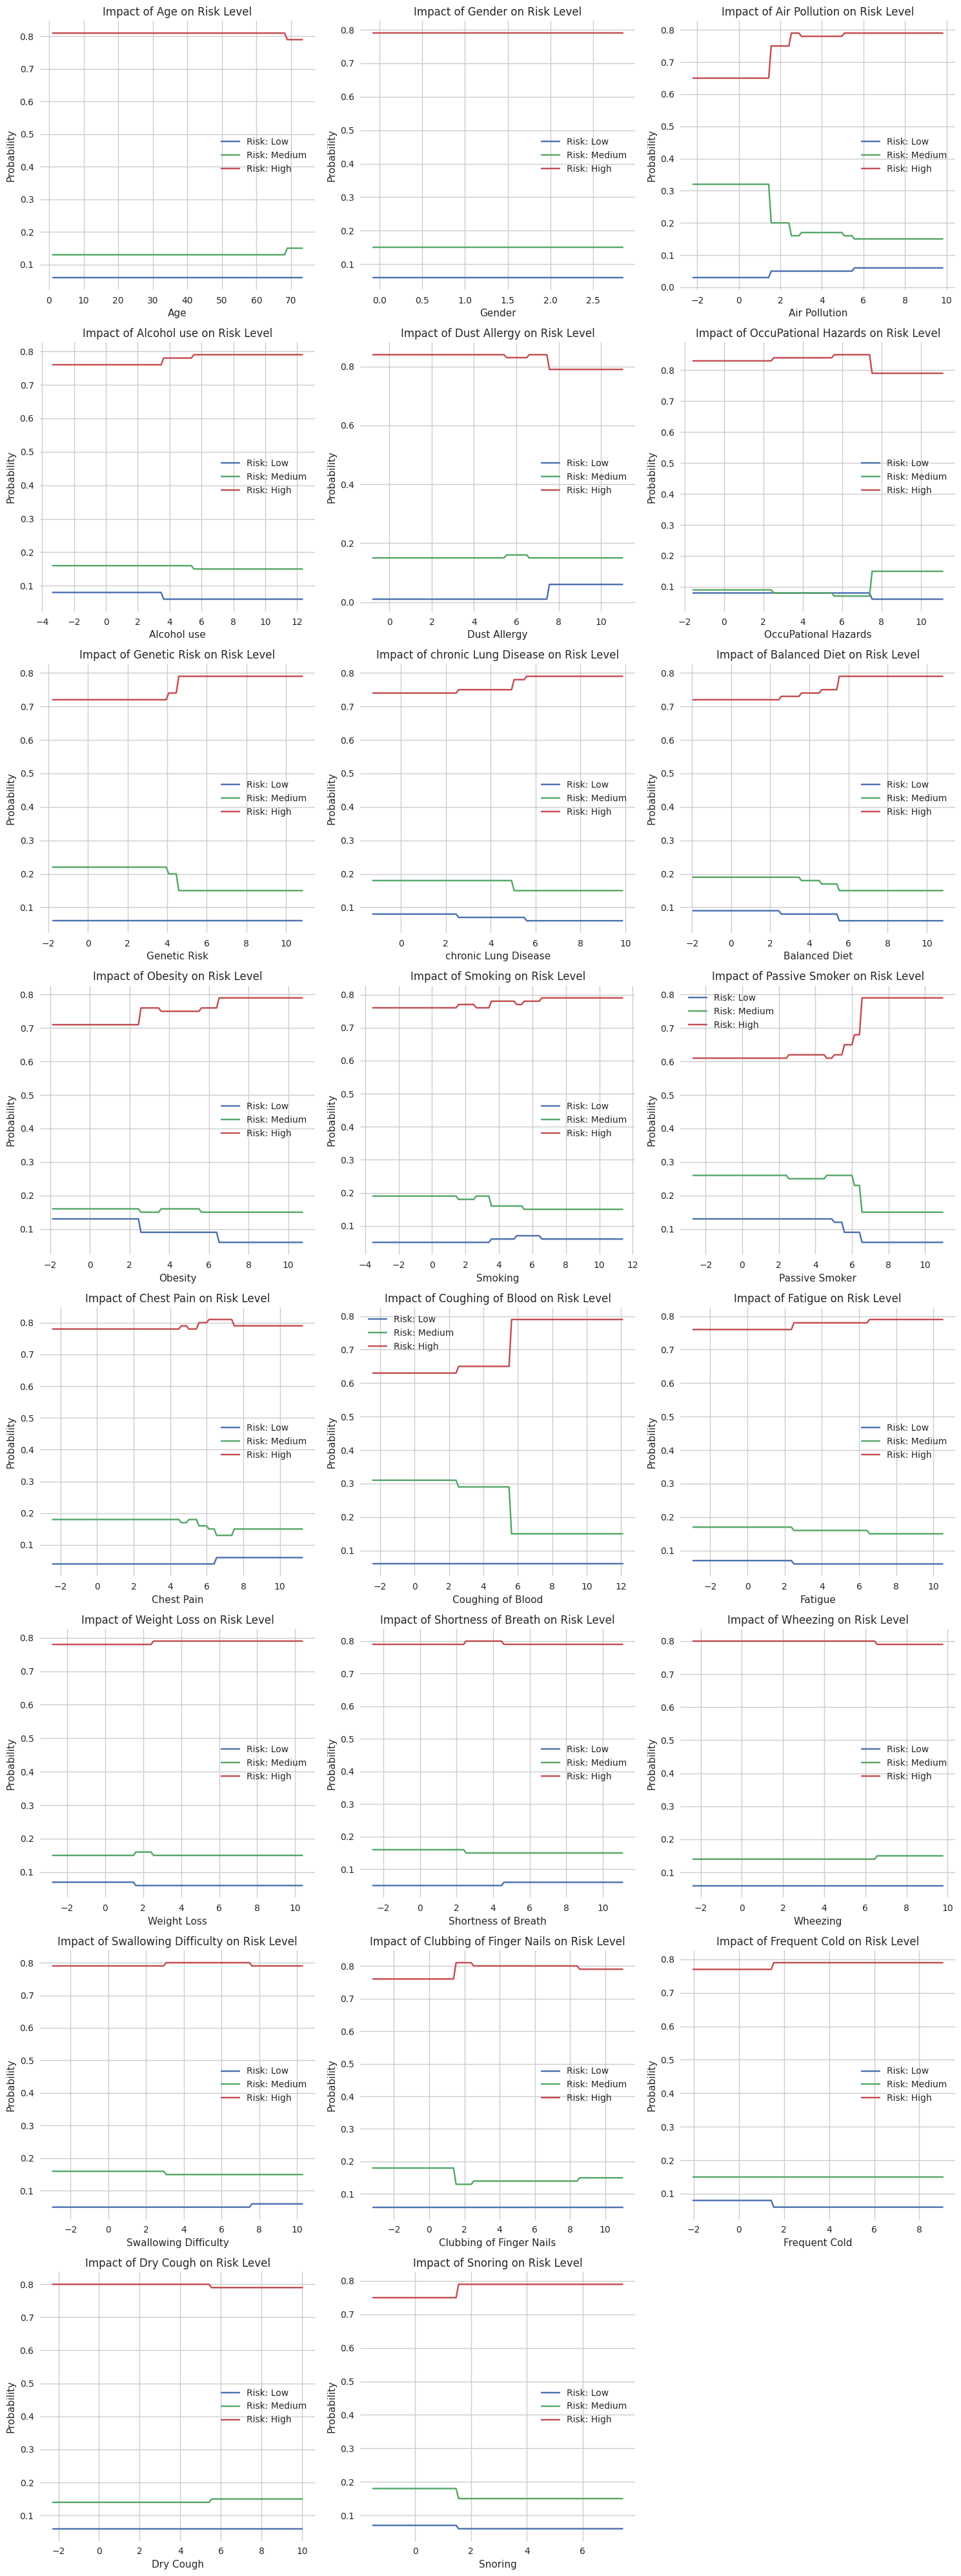


Generating sample patient risk profile...


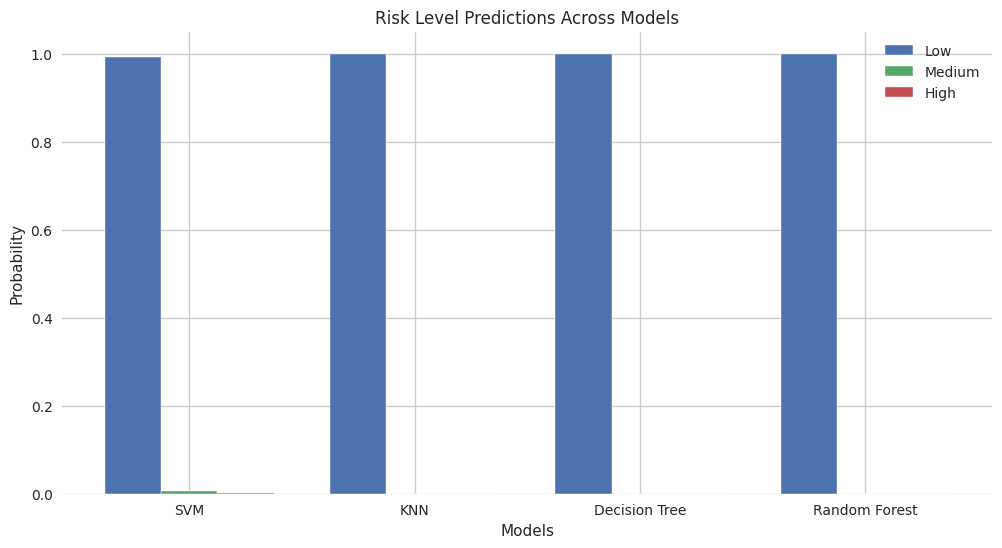


Analyzing treatment effectiveness factors...


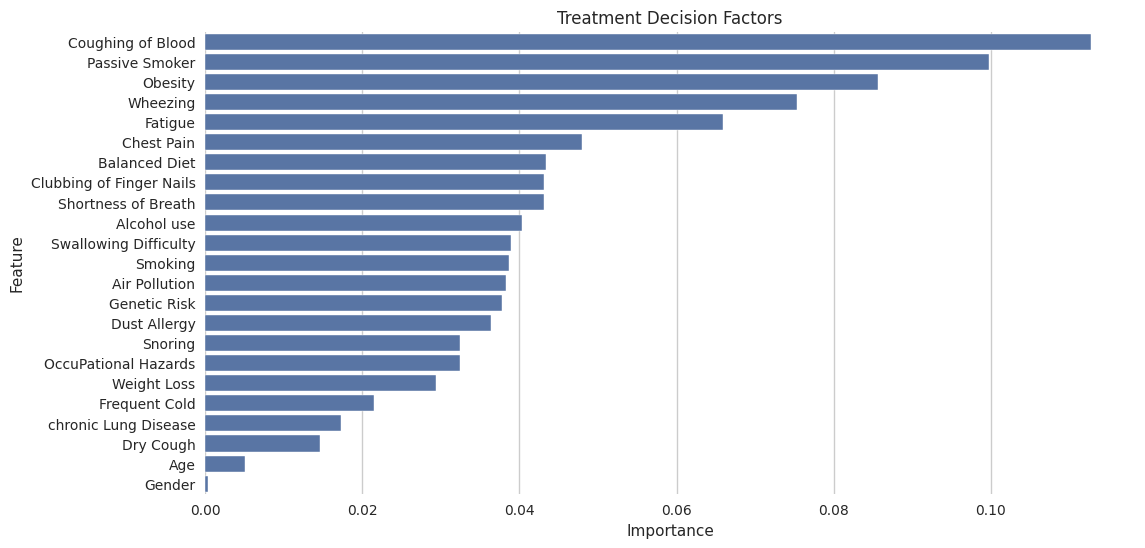


Risk Assessment Summary:
--------------------------------------------------
Model Predictions:
SVM: 0
KNN: 0
Decision Tree: 0
Random Forest: 0

Top Treatment Decision Factors:
              Feature  Importance
13  Coughing of Blood    0.112728
11     Passive Smoker    0.099777
9             Obesity    0.085630
17           Wheezing    0.075292
14            Fatigue    0.065887


In [15]:
def analyze_feature_impact(model, feature_names, scaler, class_names=['Low', 'Medium', 'High']):
    """
    Analyze how changes in each feature affect the predicted risk level.

    Parameters:
    model: Trained model
    feature_names: List of feature names
    scaler: Fitted StandardScaler
    class_names: List of class names for risk levels
    """
    # Create range of values for each feature
    n_points = 100
    feature_ranges = {}

    # Get the scaling parameters
    scale_mean = scaler.mean_
    scale_std = scaler.scale_

    for i, feature in enumerate(feature_names):
        # Create range based on scaled values (-3 to 3 standard deviations)
        scaled_range = np.linspace(-3, 3, n_points)
        # Convert back to original scale
        original_range = scaled_range * scale_std[i] + scale_mean[i]
        feature_ranges[feature] = original_range

    # Plot feature impact on predictions
    n_cols = 3
    n_rows = (len(feature_names) + n_cols - 1) // n_cols
    plt.figure(figsize=(15, 5 * n_rows))

    for i, feature in enumerate(feature_names):
        plt.subplot(n_rows, n_cols, i + 1)

        # Create test points
        X_test_points = np.tile(scale_mean, (n_points, 1))
        X_test_points[:, i] = np.linspace(-3, 3, n_points)  # Vary only one feature

        # Get predictions
        y_pred_proba = model.predict_proba(X_test_points)

        # Plot probability for each class
        for j in range(len(class_names)):
            plt.plot(feature_ranges[feature], y_pred_proba[:, j],
                    label=f'Risk: {class_names[j]}')

        plt.title(f'Impact of {feature} on Risk Level')
        plt.xlabel(feature)
        plt.ylabel('Probability')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Function to generate patient risk profile
def generate_risk_profile(patient_data, models, scaler, feature_names):
    """
    Generate comprehensive risk profile using multiple models.

    Parameters:
    patient_data: DataFrame with patient features
    models: Dictionary of trained models
    scaler: Fitted StandardScaler
    feature_names: List of feature names
    """
    # Scale patient data
    patient_scaled = scaler.transform(patient_data)

    # Get predictions from all models
    predictions = {}
    probabilities = {}

    for name, model in models.items():
        predictions[name] = model.predict(patient_scaled)
        probabilities[name] = model.predict_proba(patient_scaled)

    # Plot prediction probabilities
    plt.figure(figsize=(12, 6))
    x = np.arange(len(models))
    width = 0.25

    for i, risk_level in enumerate(['Low', 'Medium', 'High']):
        risk_probs = [probabilities[model_name][0][i] for model_name in models.keys()]
        plt.bar(x + i*width, risk_probs, width, label=risk_level)

    plt.xlabel('Models')
    plt.ylabel('Probability')
    plt.title('Risk Level Predictions Across Models')
    plt.xticks(x + width, models.keys())
    plt.legend()
    plt.show()

    return predictions, probabilities

# Function to analyze treatment effectiveness
def analyze_treatment_effectiveness(model, patient_data, scaler, feature_names):
    """
    Analyze potential treatment effectiveness based on patient characteristics.

    Parameters:
    model: Trained model (preferably Random Forest for feature importance)
    patient_data: DataFrame with patient features
    scaler: Fitted StandardScaler
    feature_names: List of feature names
    """
    # Get feature importance
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    else:
        # For models without feature_importances_, use permutation importance
        from sklearn.inspection import permutation_importance
        result = permutation_importance(model, X_test_scaled, y_test, n_repeats=10)
        importance = result.importances_mean

    # Create treatment recommendation matrix
    treatment_factors = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values('Importance', ascending=False)

    # Plot treatment factors
    plt.figure(figsize=(12, 6))
    sns.barplot(data=treatment_factors, x='Importance', y='Feature')
    plt.title('Treatment Decision Factors')
    plt.show()

    return treatment_factors

# Analyze feature impact for each model
print("Analyzing feature impact on risk levels...")
for name, model in models.items():
    print(f"\nAnalyzing {name} predictions...")
    #model_copy = models[name]
    analyze_feature_impact(model, X.columns, scaler)

# Example: Generate risk profile for a sample patient
print("\nGenerating sample patient risk profile...")
sample_patient = X.iloc[[0]]  # Using first patient as example
predictions, probabilities = generate_risk_profile(sample_patient, models, scaler, X.columns)

# Analyze treatment effectiveness using Random Forest model
print("\nAnalyzing treatment effectiveness factors...")
treatment_analysis = analyze_treatment_effectiveness(models['Random Forest'],
                                                  sample_patient,
                                                  scaler,
                                                  X.columns)

# Create summary report
print("\nRisk Assessment Summary:")
print("-" * 50)
print("Model Predictions:")
for name, pred in predictions.items():
    print(f"{name}: {pred[0]}")

print("\nTop Treatment Decision Factors:")
print(treatment_analysis.head().to_string())

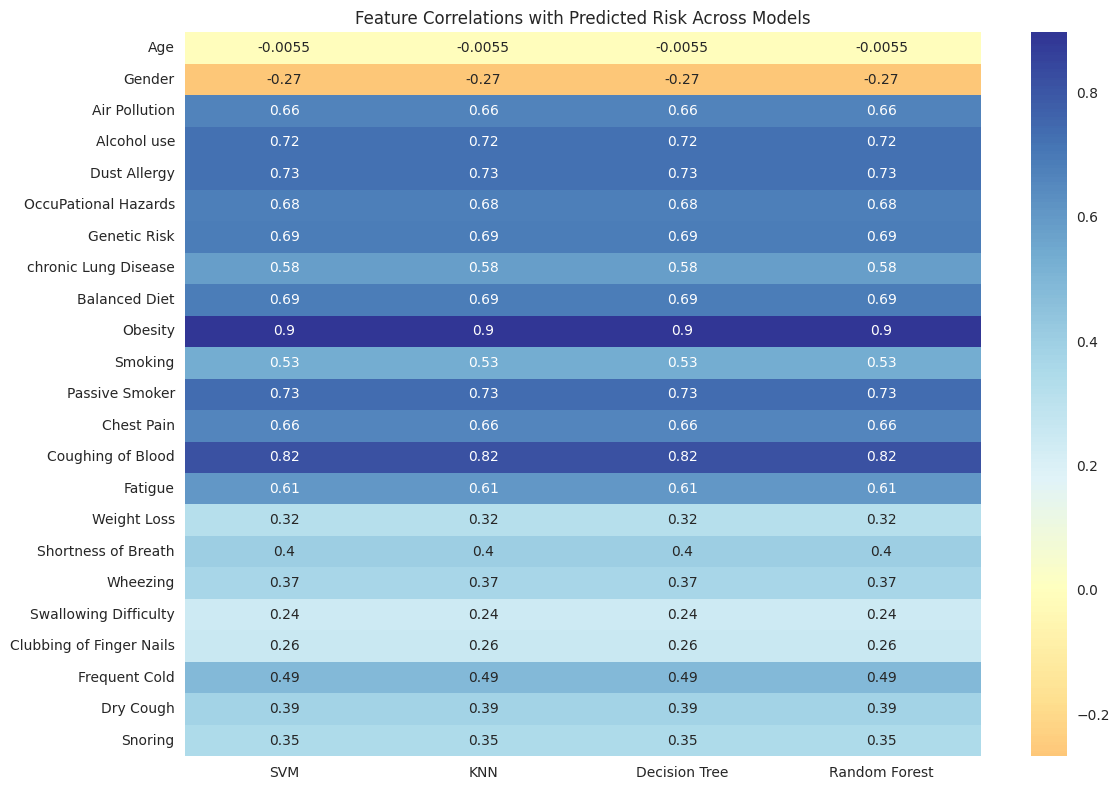

In [16]:
# Additional visualization: Risk factors correlation with predicted risk
plt.figure(figsize=(12, 8))
risk_correlations = pd.DataFrame()
for name, model in models.items():
    predictions = model.predict(X_test_scaled)
    temp_df = pd.DataFrame(X_test_scaled, columns=X.columns)
    temp_df['predicted_risk'] = predictions
    correlations = temp_df.corr()['predicted_risk'].drop('predicted_risk')
    risk_correlations[name] = correlations

sns.heatmap(risk_correlations, annot=True, cmap='RdYlBu', center=0)
plt.title('Feature Correlations with Predicted Risk Across Models')
plt.tight_layout()
plt.savefig("feature_correlations.png")
plt.show()

In [17]:
# Function to get personalized treatment recommendations
def get_treatment_recommendations(patient_data, model, scaler, feature_importance):
    """
    Generate personalized treatment recommendations based on patient characteristics.
    """
    # Scale patient data
    patient_scaled = scaler.transform(patient_data)

    # Get prediction and probabilities
    risk_level = model.predict(patient_scaled)[0]
    risk_probs = model.predict_proba(patient_scaled)[0]

    # Identify key risk factors
    patient_values = pd.DataFrame(patient_scaled, columns=X.columns)
    risk_factors = []
    for feature, importance in zip(X.columns, feature_importance):
        if importance > np.mean(feature_importance):
            value = patient_values[feature].iloc[0]
            if abs(value) > 1:  # If value is more than 1 std dev from mean
                risk_factors.append((feature, value, importance))

    return risk_level, risk_probs, risk_factors

# Generate recommendations for sample patient
print("\nGenerating Treatment Recommendations...")
risk_level, risk_probs, risk_factors = get_treatment_recommendations(
    sample_patient,
    models['Random Forest'],
    scaler,
    models['Random Forest'].feature_importances_
)

print(f"\nRisk Level: {risk_level}")
print("\nRisk Probabilities:")
for level, prob in zip(['Low', 'Medium', 'High'], risk_probs):
    print(f"{level}: {prob:.2%}")

print("\nKey Risk Factors:")
for feature, value, importance in sorted(risk_factors, key=lambda x: x[2], reverse=True):
    print(f"{feature}: {value:.2f} std. dev. from mean (Importance: {importance:.3f})")


Generating Treatment Recommendations...

Risk Level: 0

Risk Probabilities:
Low: 100.00%
Medium: 0.00%
High: 0.00%

Key Risk Factors:
Chest Pain: -1.05 std. dev. from mean (Importance: 0.048)


# **Comprehensive Risk Level Analysis**

In [18]:
def analyze_all_risk_levels(df, models, scaler, X_columns):
    """
    Analyze characteristics and patterns for all risk levels in the dataset.

    Parameters:
    df: Original dataframe with all data
    models: Dictionary of trained models
    scaler: Fitted StandardScaler
    X_columns: Feature column names
    """
    # Get predictions from Random Forest (most reliable for feature importance)
    rf_model = models['Random Forest']
    X_scaled = scaler.transform(df[X_columns])
    predictions = rf_model.predict(X_scaled)

    # Create DataFrame with original features and predictions
    analysis_df = df.copy()
    analysis_df['Predicted_Risk'] = predictions

    # Analyze characteristics of each risk level
    risk_levels = sorted(analysis_df['Predicted_Risk'].unique())

    # Plot distribution of features for each risk level
    for feature in X_columns:
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='Predicted_Risk', y=feature, data=analysis_df)
        plt.title(f'Distribution of {feature} by Risk Level')
        plt.show()

        # Add statistical test
        from scipy import stats
        f_stat, p_val = stats.f_oneway(*[
            analysis_df[analysis_df['Predicted_Risk'] == level][feature]
            for level in risk_levels
        ])
        print(f"\nANOVA test for {feature}:")
        print(f"F-statistic: {f_stat:.4f}")
        print(f"p-value: {p_val:.4f}")

    # Create profile for each risk level
    risk_profiles = {}
    for level in risk_levels:
        level_data = analysis_df[analysis_df['Predicted_Risk'] == level]
        profile = {
            'count': len(level_data),
            'percentage': len(level_data) / len(analysis_df) * 100,
            'characteristics': {}
        }

        # Calculate mean and std for each feature
        for feature in X_columns:
            profile['characteristics'][feature] = {
                'mean': level_data[feature].mean(),
                'std': level_data[feature].std(),
                'median': level_data[feature].median()
            }

        risk_profiles[level] = profile

    return risk_profiles, analysis_df

In [19]:
def visualize_risk_patterns(risk_profiles, analysis_df, X_columns):
    """
    Create visualizations for risk patterns and characteristics.
    """
    # Plot risk level distribution
    plt.figure(figsize=(10, 6))
    sns.countplot(data=analysis_df, x='Predicted_Risk')
    plt.title('Distribution of Risk Levels')
    plt.show()

    # Create radar chart for feature patterns
    risk_levels = sorted(risk_profiles.keys())
    features = X_columns

    # Prepare data for radar chart
    angles = np.linspace(0, 2*np.pi, len(features), endpoint=False)

    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(projection='polar'))

    for level in risk_levels:
        values = [risk_profiles[level]['characteristics'][feat]['mean'] for feat in features]
        values = np.concatenate((values, [values[0]]))  # complete the circle
        angles_plot = np.concatenate((angles, [angles[0]]))  # complete the circle

        ax.plot(angles_plot, values, 'o-', linewidth=2, label=f'Risk Level {level}')
        ax.fill(angles_plot, values, alpha=0.25)

    ax.set_xticks(angles)
    ax.set_xticklabels(features)
    plt.legend(bbox_to_anchor=(1.3, 1.0))
    plt.title('Feature Patterns by Risk Level')
    plt.show()

In [20]:
from scipy import stats

def generate_treatment_recommendations_v2(patient_data, risk_profiles, scaler, X_columns, rf_model):
    """
    Generate detailed treatment recommendations based on comprehensive risk analysis.
    """
    # Scale patient data
    patient_scaled = scaler.transform(patient_data[X_columns])

    # Get prediction and probabilities
    risk_level = rf_model.predict(patient_scaled)[0]
    risk_probs = rf_model.predict_proba(patient_scaled)[0]

    # Compare patient values with risk level profiles
    patient_profile = {}
    significant_deviations = []

    for feature in X_columns:
        patient_value = patient_data[feature].iloc[0]
        risk_mean = risk_profiles[risk_level]['characteristics'][feature]['mean']
        risk_std = risk_profiles[risk_level]['characteristics'][feature]['std']

        z_score = (patient_value - risk_mean) / risk_std
        patient_profile[feature] = {
            'value': patient_value,
            'z_score': z_score,
            'percentile': stats.norm.cdf(z_score) * 100
        }

        if abs(z_score) > 1.5:  # Significant deviation
            significant_deviations.append((feature, z_score))

    return {
        'risk_level': risk_level,
        'risk_probabilities': risk_probs,
        'profile': patient_profile,
        'significant_deviations': significant_deviations
    }

Performing comprehensive risk level analysis...


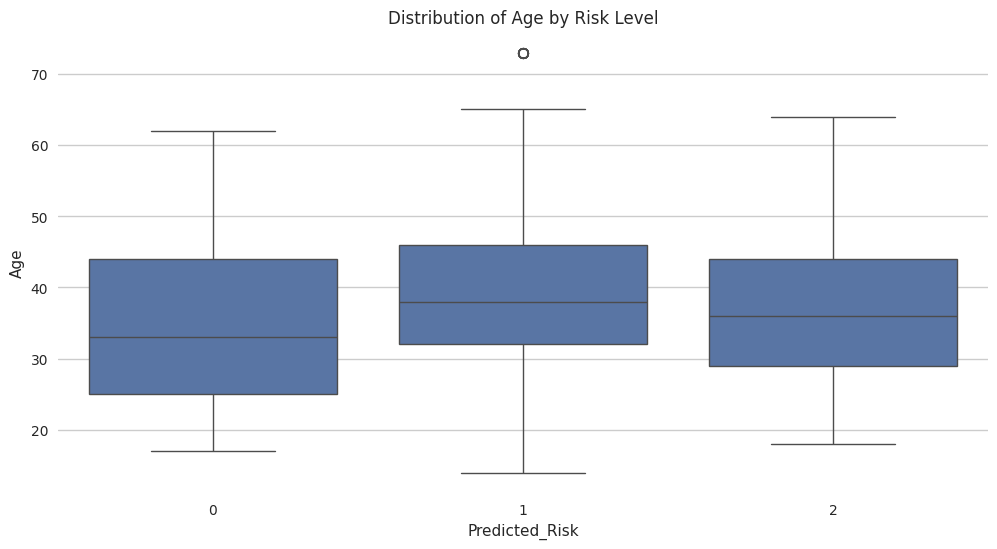


ANOVA test for Age:
F-statistic: 5.7525
p-value: 0.0033


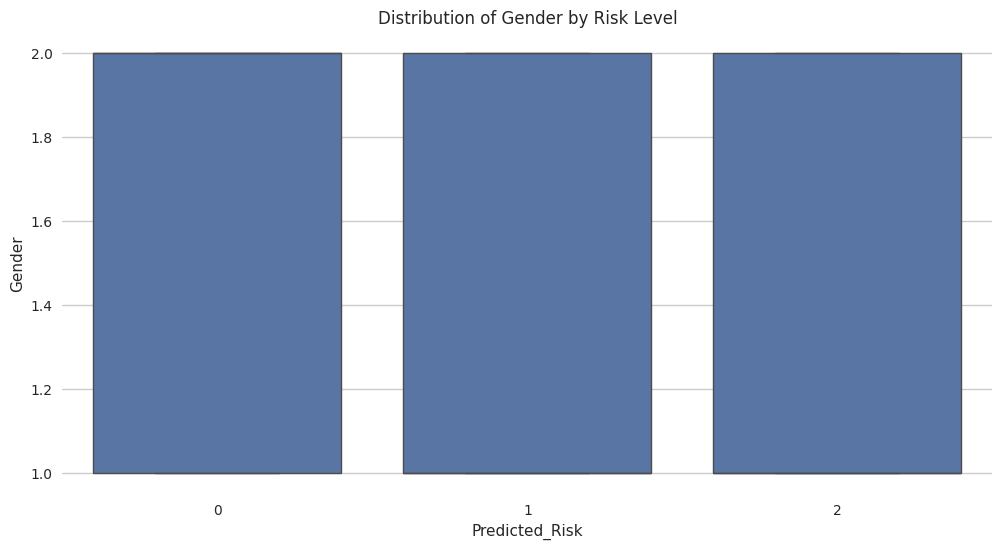


ANOVA test for Gender:
F-statistic: 13.9515
p-value: 0.0000


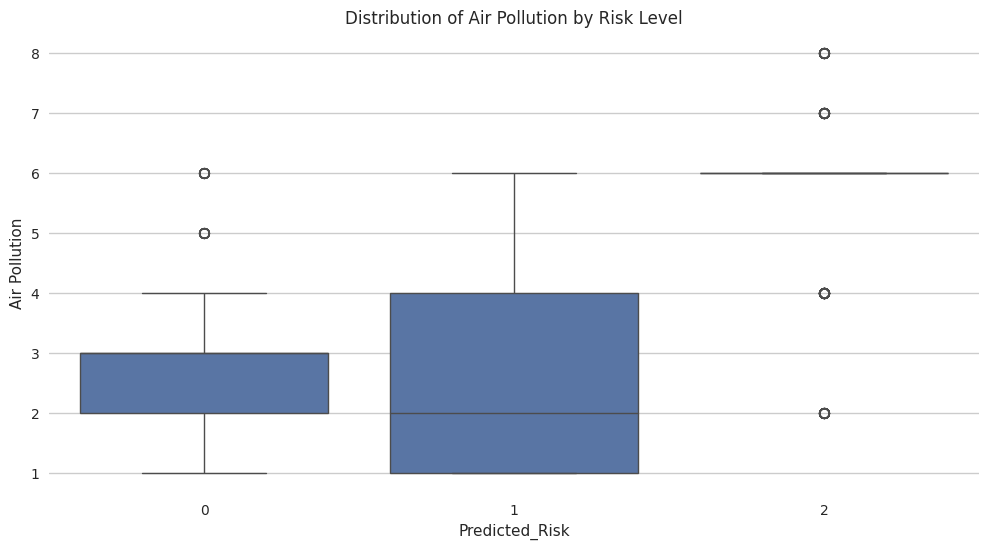


ANOVA test for Air Pollution:
F-statistic: 466.7856
p-value: 0.0000


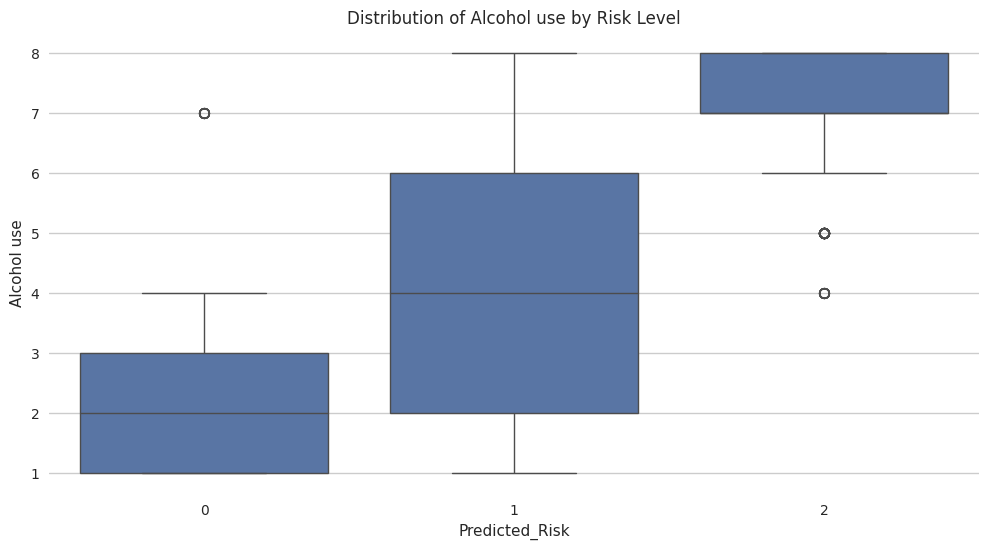


ANOVA test for Alcohol use:
F-statistic: 540.2431
p-value: 0.0000


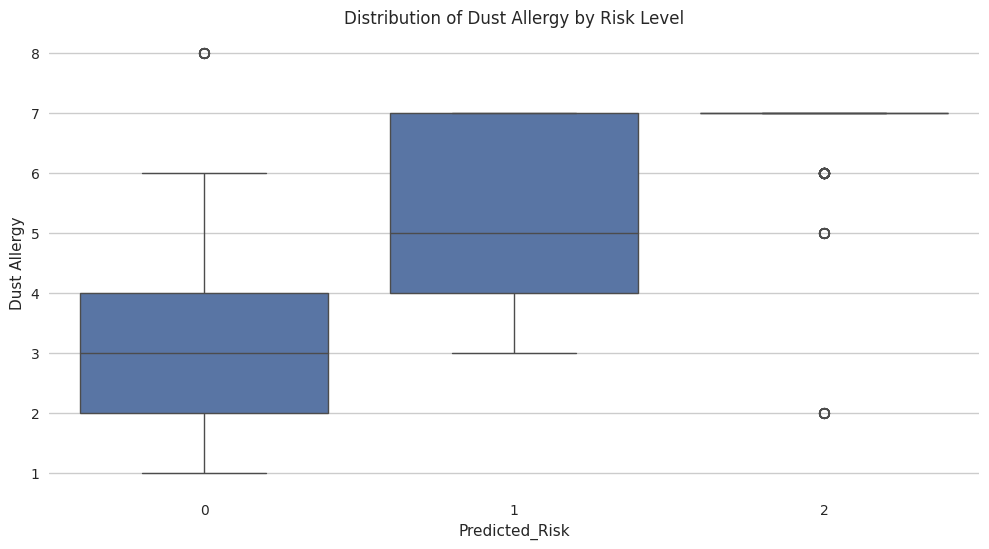


ANOVA test for Dust Allergy:
F-statistic: 558.6354
p-value: 0.0000


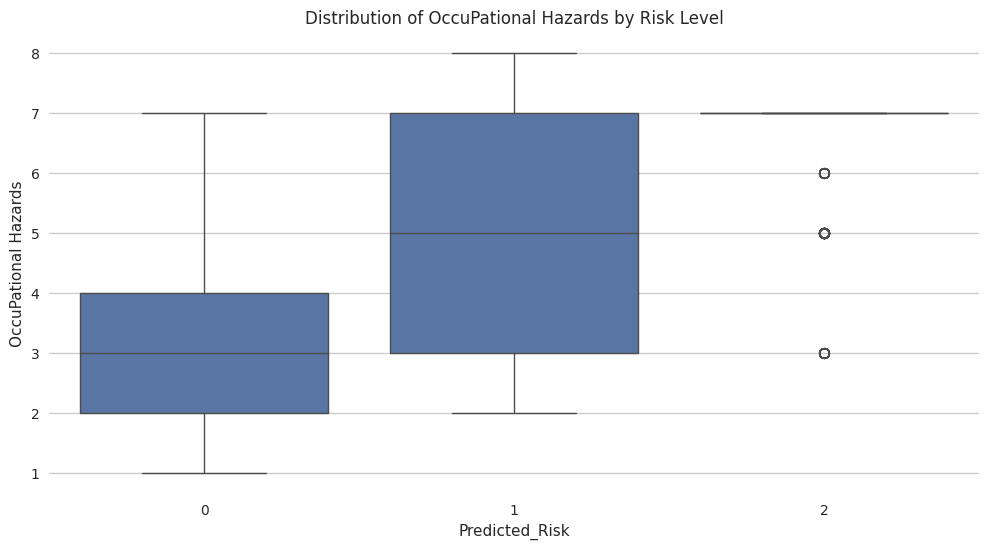


ANOVA test for OccuPational Hazards:
F-statistic: 413.3316
p-value: 0.0000


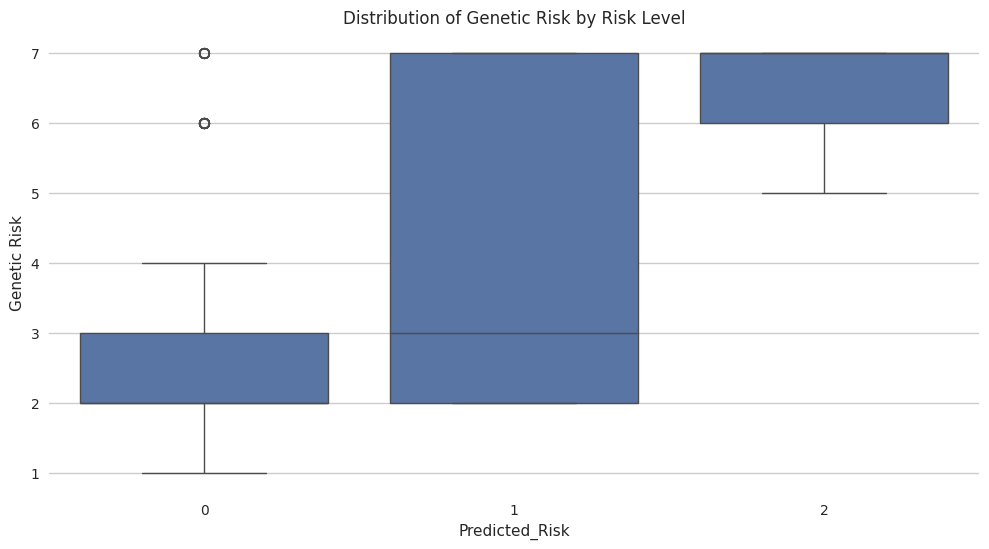


ANOVA test for Genetic Risk:
F-statistic: 488.9808
p-value: 0.0000


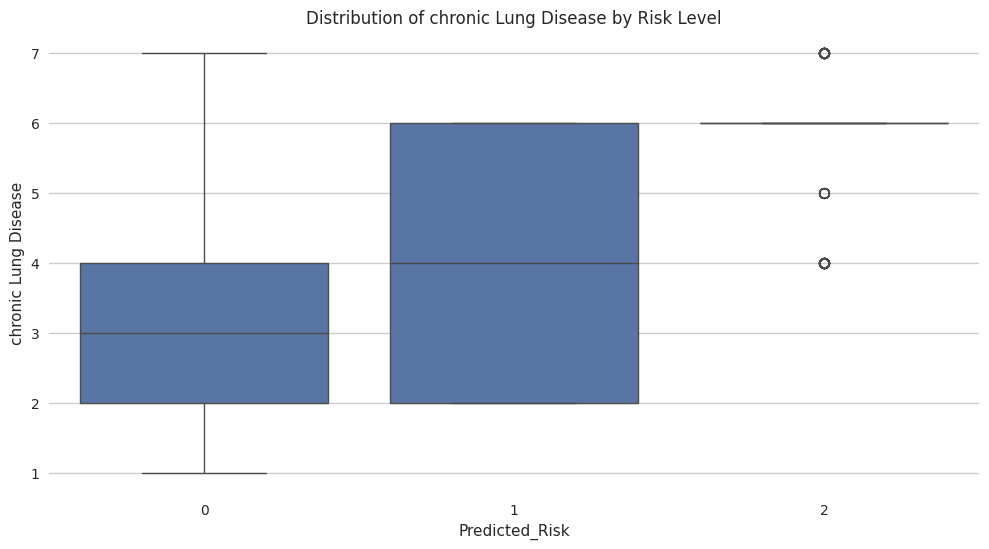


ANOVA test for chronic Lung Disease:
F-statistic: 316.0496
p-value: 0.0000


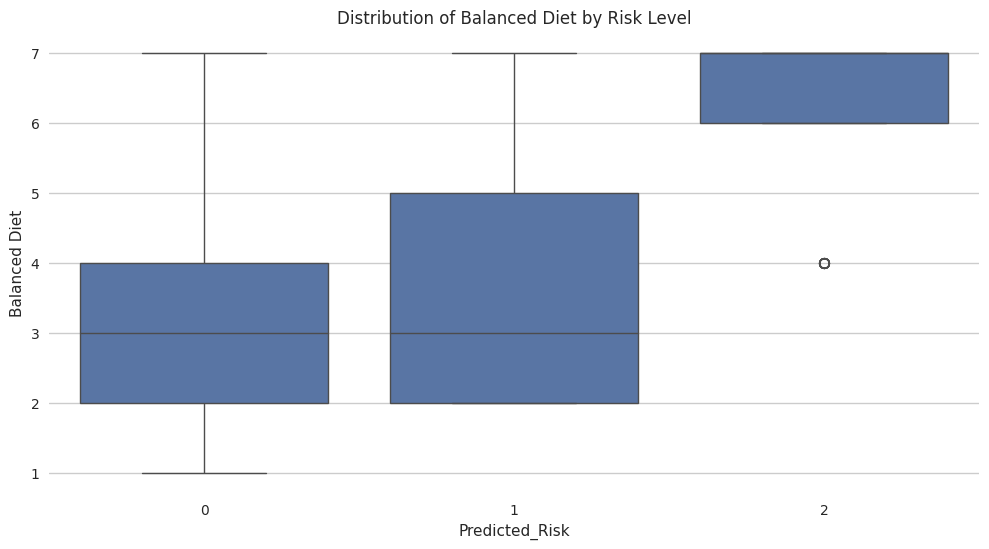


ANOVA test for Balanced Diet:
F-statistic: 689.9379
p-value: 0.0000


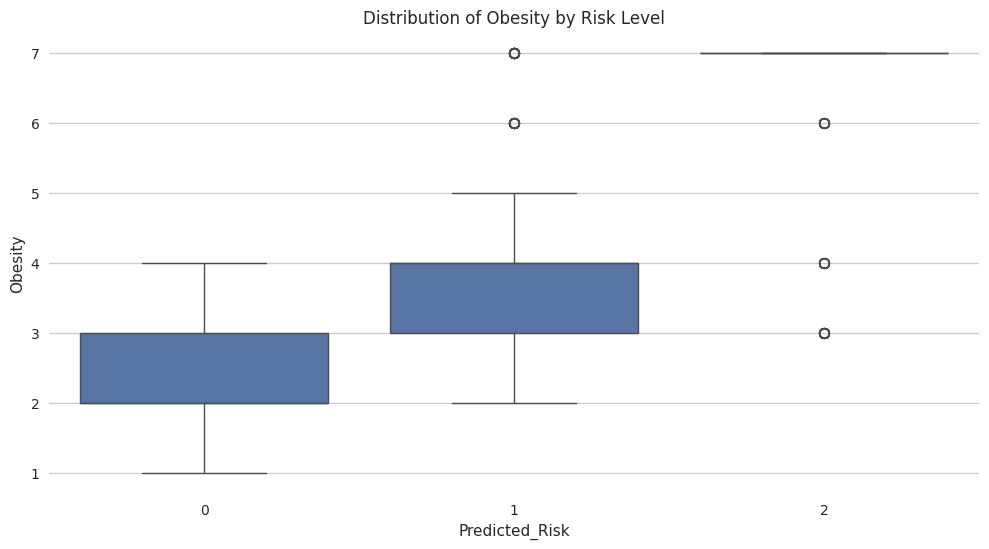


ANOVA test for Obesity:
F-statistic: 1190.5367
p-value: 0.0000


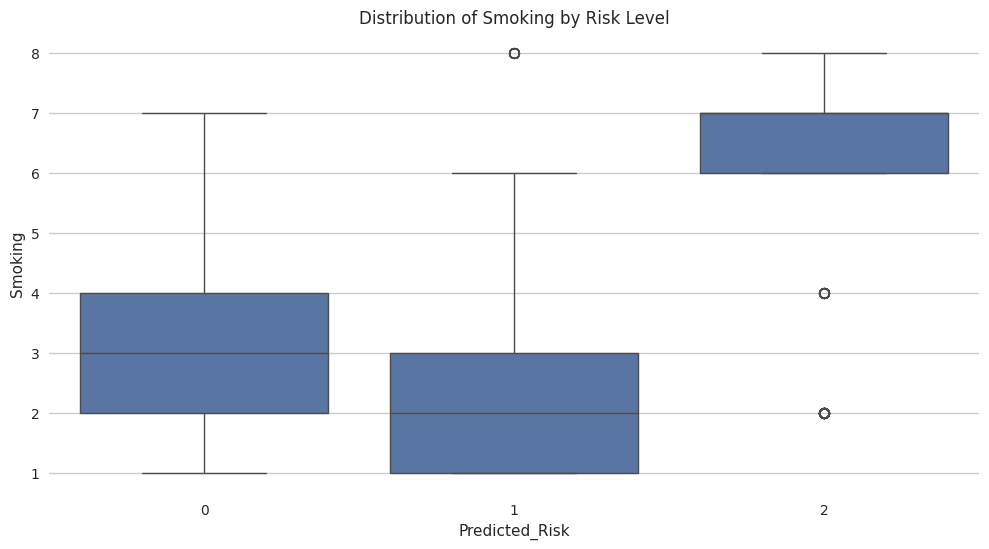


ANOVA test for Smoking:
F-statistic: 369.4830
p-value: 0.0000


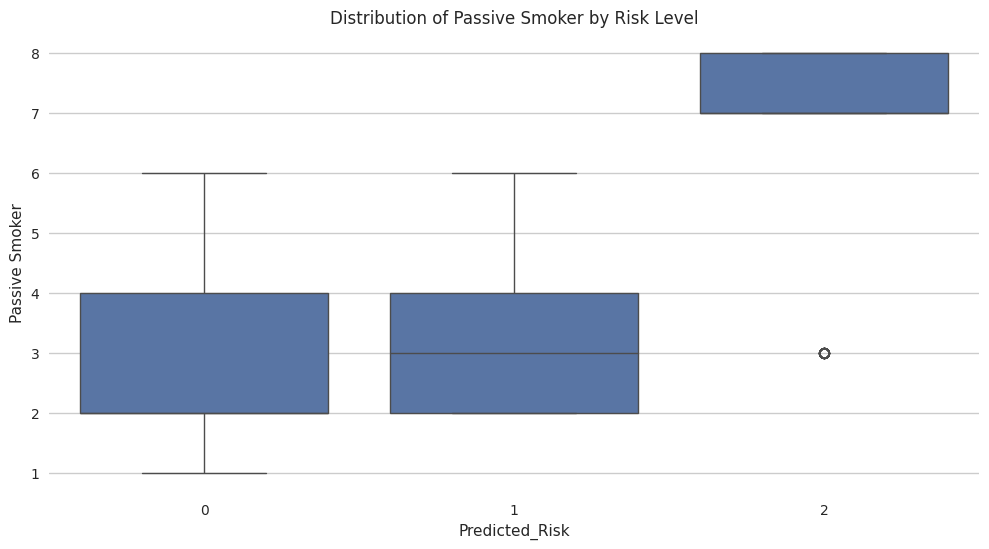


ANOVA test for Passive Smoker:
F-statistic: 722.1891
p-value: 0.0000


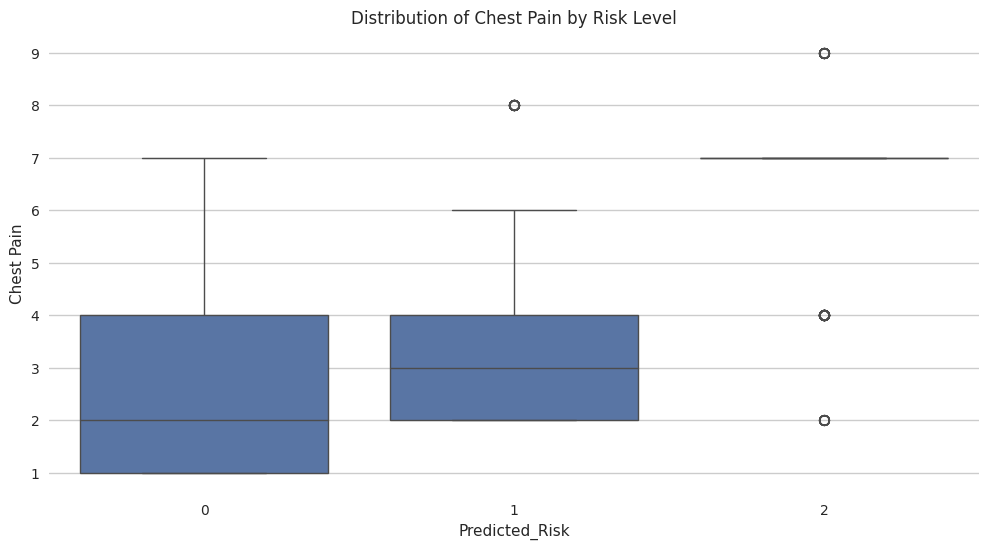


ANOVA test for Chest Pain:
F-statistic: 404.8011
p-value: 0.0000


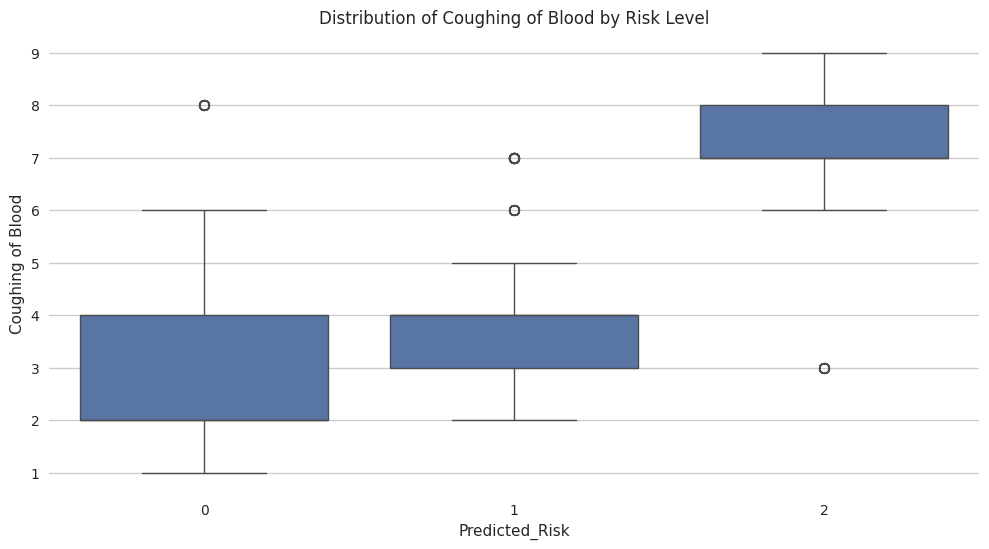


ANOVA test for Coughing of Blood:
F-statistic: 1037.5586
p-value: 0.0000


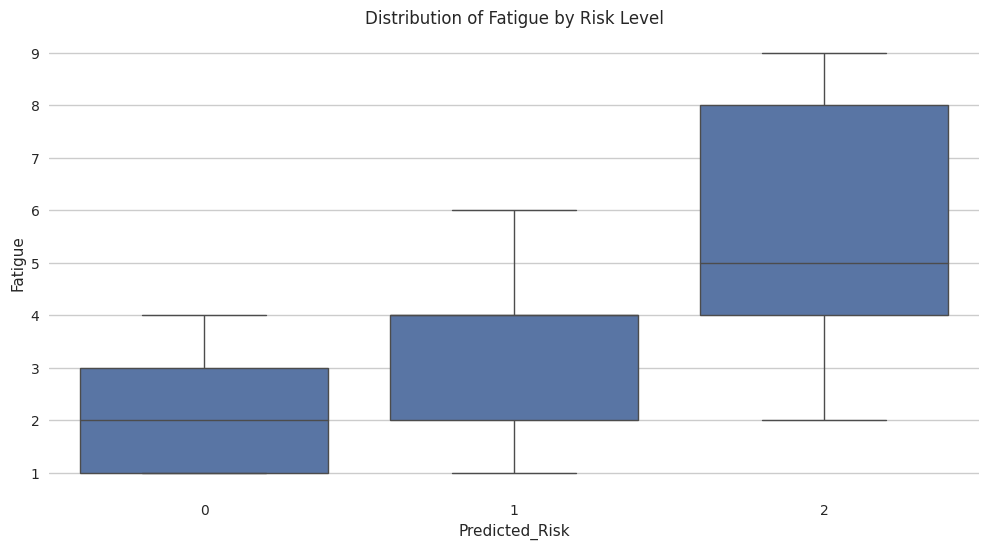


ANOVA test for Fatigue:
F-statistic: 328.9289
p-value: 0.0000


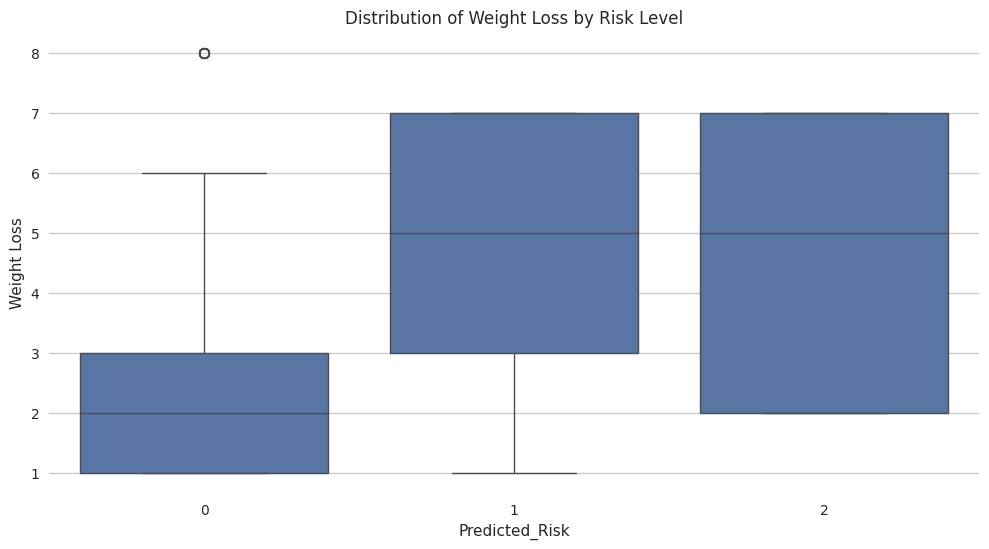


ANOVA test for Weight Loss:
F-statistic: 97.6464
p-value: 0.0000


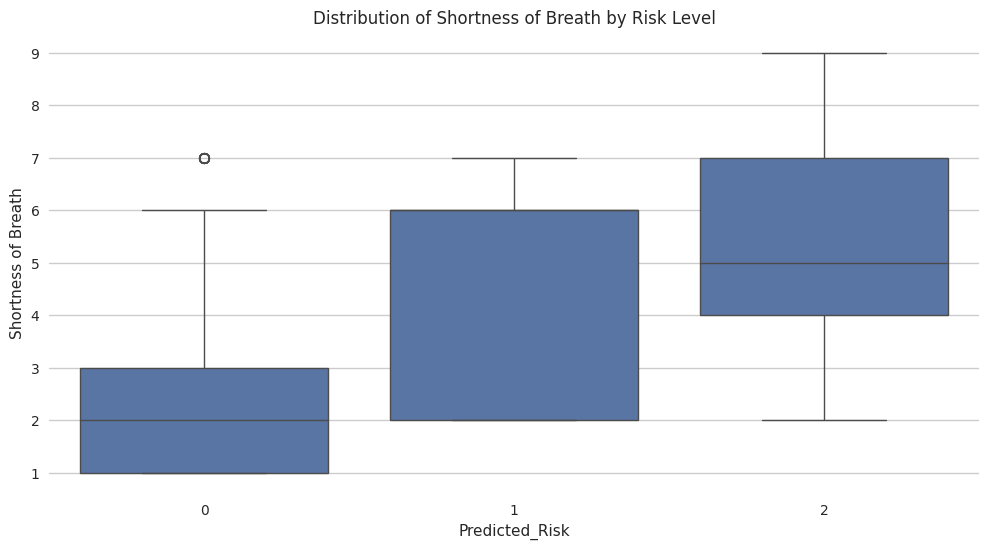


ANOVA test for Shortness of Breath:
F-statistic: 183.3929
p-value: 0.0000


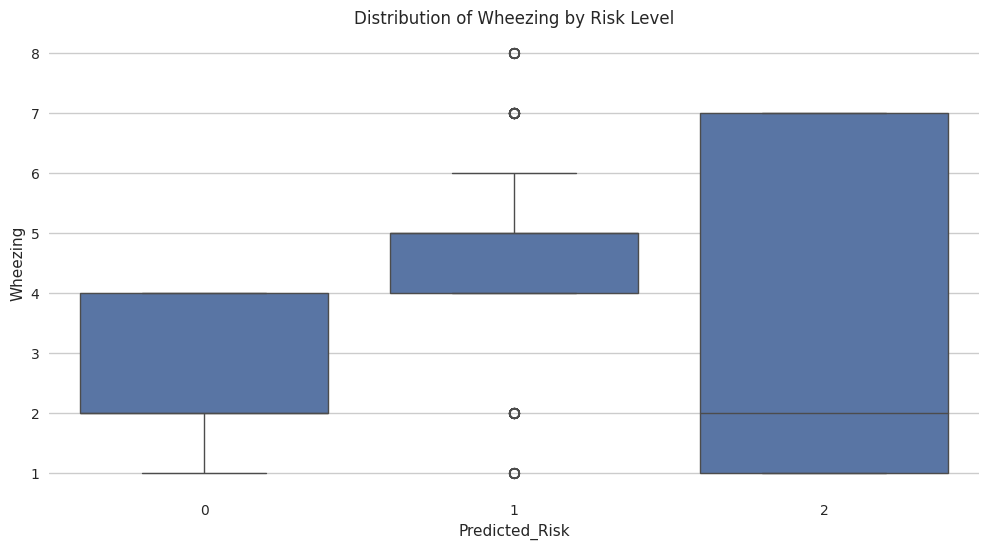


ANOVA test for Wheezing:
F-statistic: 111.3978
p-value: 0.0000


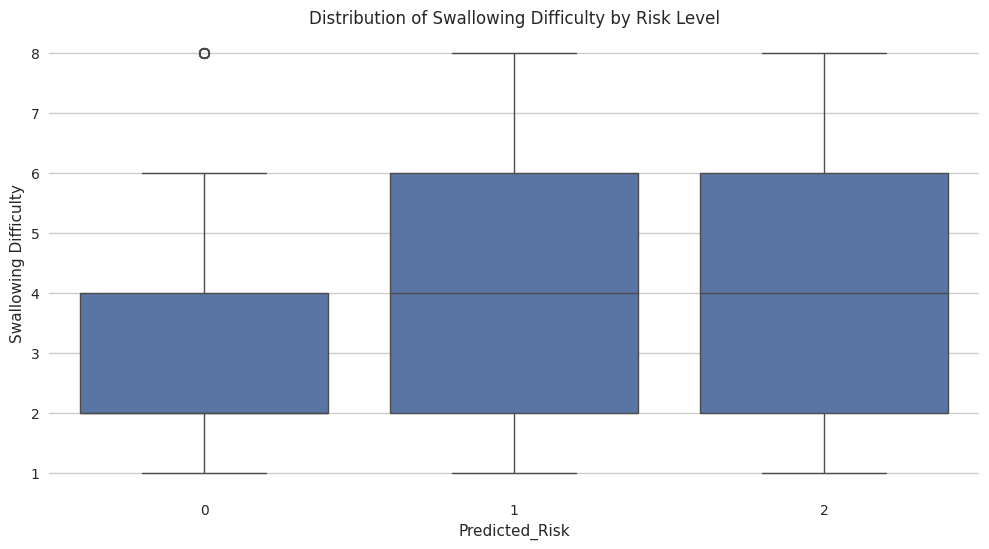


ANOVA test for Swallowing Difficulty:
F-statistic: 44.6798
p-value: 0.0000


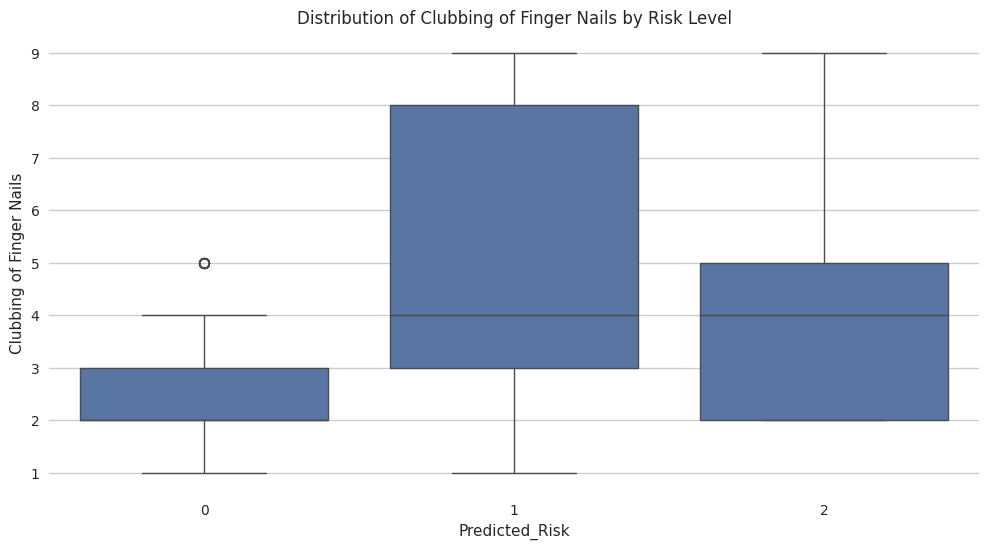


ANOVA test for Clubbing of Finger Nails:
F-statistic: 107.6491
p-value: 0.0000


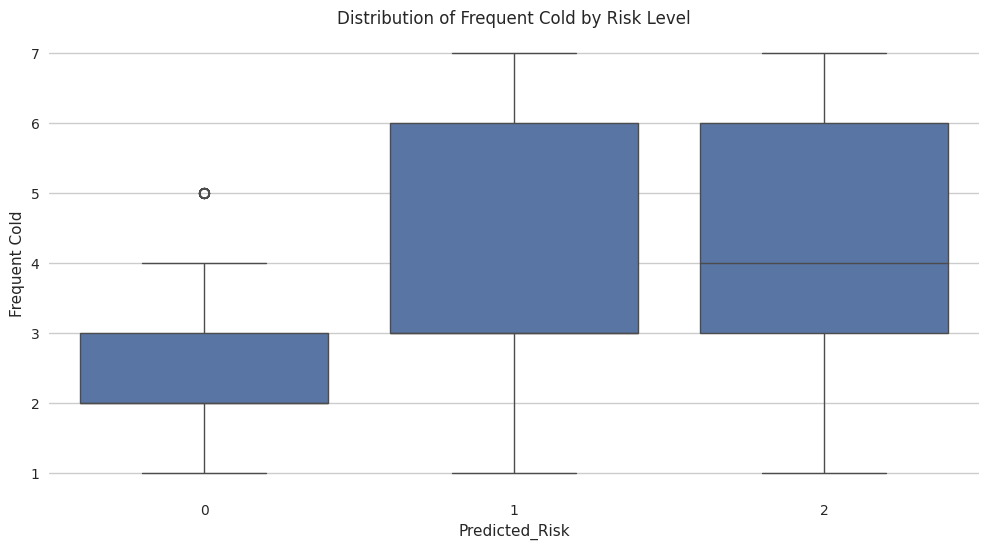


ANOVA test for Frequent Cold:
F-statistic: 127.0709
p-value: 0.0000


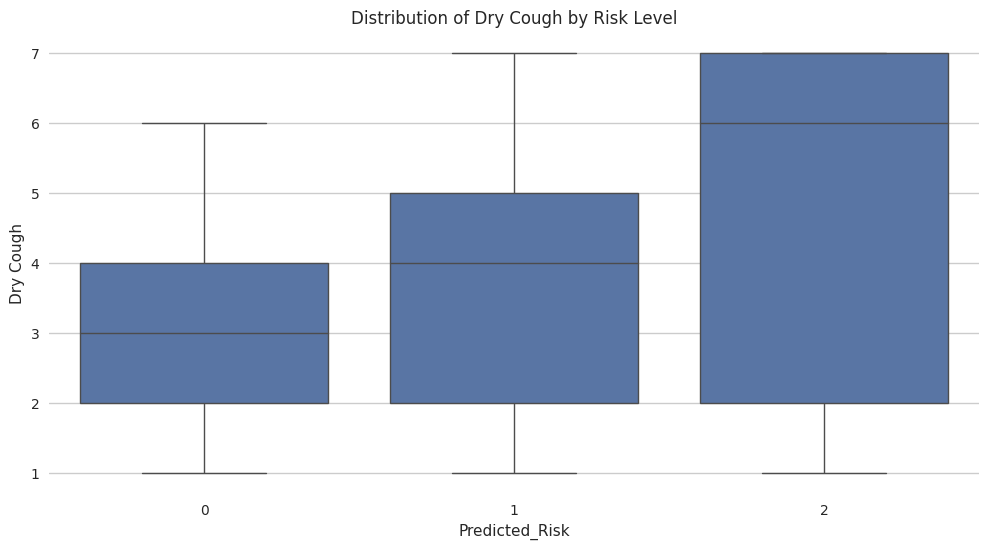


ANOVA test for Dry Cough:
F-statistic: 81.8490
p-value: 0.0000


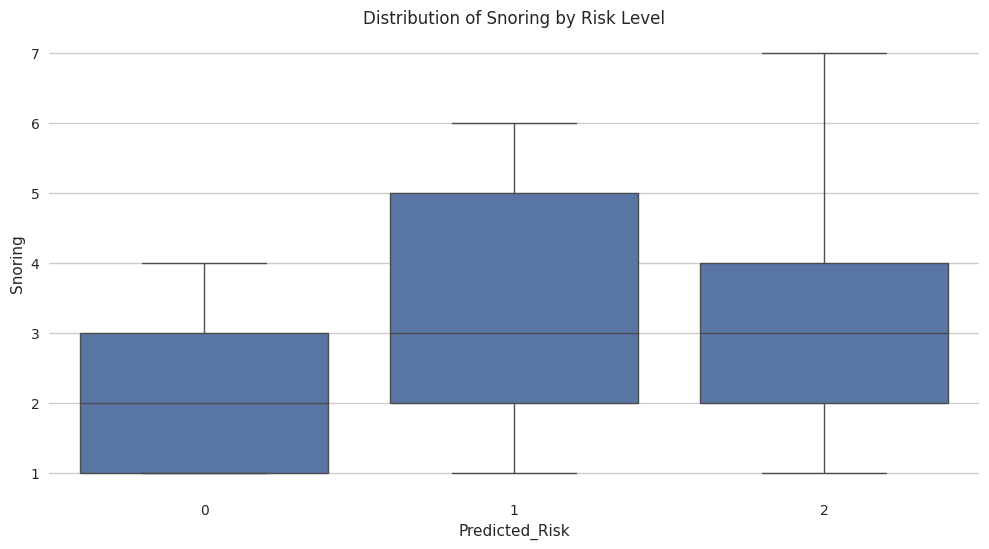


ANOVA test for Snoring:
F-statistic: 70.2836
p-value: 0.0000

Visualizing risk patterns...


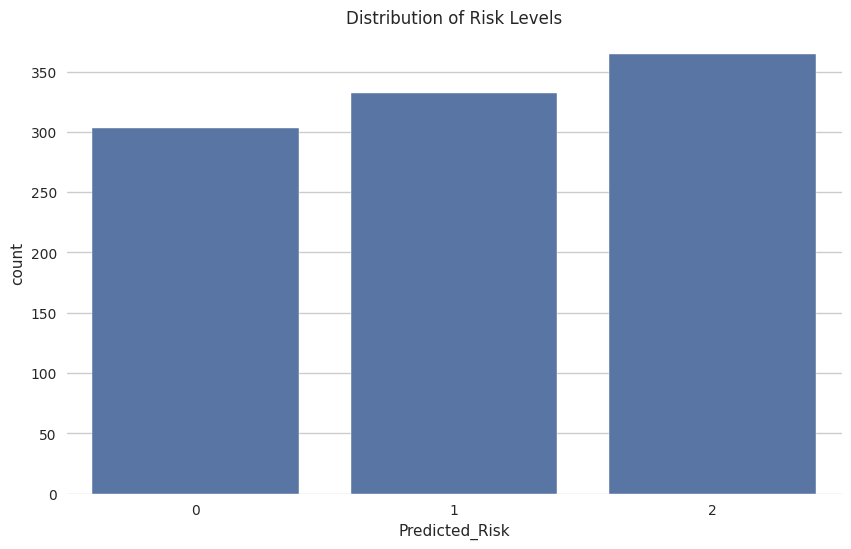

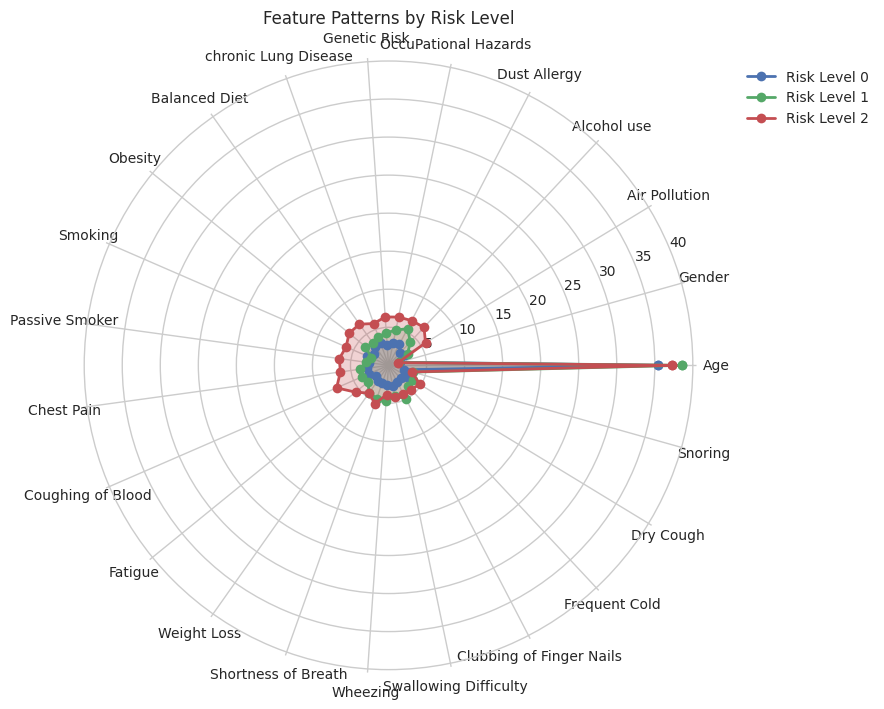


Generating detailed treatment recommendations...


In [21]:
# Perform comprehensive risk analysis
print("Performing comprehensive risk level analysis...")
risk_profiles, analysis_df = analyze_all_risk_levels(df, models, scaler, X.columns)

# Visualize risk patterns
print("\nVisualizing risk patterns...")
visualize_risk_patterns(risk_profiles, analysis_df, X.columns)

# Generate comprehensive recommendations for sample patient
print("\nGenerating detailed treatment recommendations...")
recommendations = generate_treatment_recommendations_v2(
    sample_patient,
    risk_profiles,
    scaler,
    X.columns,
    models['Random Forest']
)

In [22]:
# Print detailed analysis
print("\nDetailed Risk Analysis:")
print("-" * 50)
print(f"Predicted Risk Level: {recommendations['risk_level']}")
print("\nRisk Probabilities:")
for level, prob in zip(['Low', 'Medium', 'High'], recommendations['risk_probabilities']):
    print(f"{level}: {prob:.2%}")

print("\nSignificant Feature Deviations:")
for feature, z_score in recommendations['significant_deviations']:
    direction = "above" if z_score > 0 else "below"
    print(f"{feature}: {abs(z_score):.2f} standard deviations {direction} typical for this risk level")

print("\nDetailed Feature Profile:")
for feature, stats in recommendations['profile'].items():
    print(f"\n{feature}:")
    print(f"  Value: {stats['value']:.2f}")
    print(f"  Percentile: {stats['percentile']:.1f}%")
    print(f"  Standard deviations from mean: {stats['z_score']:.2f}")



Detailed Risk Analysis:
--------------------------------------------------
Predicted Risk Level: 0

Risk Probabilities:
Low: 100.00%
Medium: 0.00%
High: 0.00%

Significant Feature Deviations:
Obesity: 1.51 standard deviations above typical for this risk level
Snoring: 1.81 standard deviations above typical for this risk level

Detailed Feature Profile:

Age:
  Value: 33.00
  Percentile: 42.1%
  Standard deviations from mean: -0.20

Gender:
  Value: 1.00
  Percentile: 15.5%
  Standard deviations from mean: -1.01

Air Pollution:
  Value: 2.00
  Percentile: 29.4%
  Standard deviations from mean: -0.54

Alcohol use:
  Value: 4.00
  Percentile: 92.0%
  Standard deviations from mean: 1.40

Dust Allergy:
  Value: 5.00
  Percentile: 87.2%
  Standard deviations from mean: 1.14

OccuPational Hazards:
  Value: 4.00
  Percentile: 74.4%
  Standard deviations from mean: 0.66

Genetic Risk:
  Value: 3.00
  Percentile: 57.4%
  Standard deviations from mean: 0.19

chronic Lung Disease:
  Value: 2.00
 

In [23]:
from scipy import stats as stats_module

# Add statistical significance testing
print("\nStatistical Significance Tests:")
print("-" * 50)
for feature in X.columns:
    groups = [analysis_df[analysis_df['Predicted_Risk'] == level][feature]
             for level in sorted(analysis_df['Predicted_Risk'].unique())]

    # Perform Kruskal-Wallis H-test (non-parametric ANOVA)
    h_stat, p_val = stats_module.kruskal(*groups)
    print(f"\n{feature}:")
    print(f"H-statistic: {h_stat:.4f}")
    print(f"p-value: {p_val:.4f}")
    if p_val < 0.05:
        print("*** Statistically significant difference between risk levels")


Statistical Significance Tests:
--------------------------------------------------

Age:
H-statistic: 14.8972
p-value: 0.0006
*** Statistically significant difference between risk levels

Gender:
H-statistic: 27.1977
p-value: 0.0000
*** Statistically significant difference between risk levels

Air Pollution:
H-statistic: 463.1429
p-value: 0.0000
*** Statistically significant difference between risk levels

Alcohol use:
H-statistic: 466.4868
p-value: 0.0000
*** Statistically significant difference between risk levels

Dust Allergy:
H-statistic: 505.8996
p-value: 0.0000
*** Statistically significant difference between risk levels

OccuPational Hazards:
H-statistic: 436.5774
p-value: 0.0000
*** Statistically significant difference between risk levels

Genetic Risk:
H-statistic: 456.4610
p-value: 0.0000
*** Statistically significant difference between risk levels

chronic Lung Disease:
H-statistic: 392.7780
p-value: 0.0000
*** Statistically significant difference between risk levels

Bala

# **Risk Based Treatment Protocol Analysis**

In [24]:
def define_treatment_protocols():
    """
    Define standard treatment protocols for different risk levels and conditions.
    Returns dictionary of treatment protocols.
    """
    return {
        'Low': {
            'primary_treatments': [
                'Regular monitoring and screening',
                'Smoking cessation programs',
                'Preventive care'
            ],
            'screening_frequency': '6 months',
            'lifestyle_recommendations': [
                'Smoking cessation',
                'Regular exercise',
                'Healthy diet',
                'Air quality monitoring'
            ],
            'monitoring_tests': [
                'Annual chest X-ray',
                'Pulmonary function tests',
                'Regular physical examinations'
            ]
        },
        'Medium': {
            'primary_treatments': [
                'Enhanced screening protocol',
                'Preventive therapy consideration',
                'Specialized pulmonary consultation'
            ],
            'screening_frequency': '3 months',
            'additional_tests': [
                'CT screening',
                'Sputum cytology',
                'Bronchoscopy (if indicated)'
            ],
            'lifestyle_recommendations': [
                'Immediate smoking cessation',
                'Pulmonary rehabilitation',
                'Occupational exposure reduction',
                'Air quality improvement'
            ],
            'monitoring_tests': [
                'Quarterly chest imaging',
                'Regular pulmonary function testing',
                'Blood biomarker monitoring'
            ]
        },
        'High': {
            'primary_treatments': [
                'Immediate oncology consultation',
                'Biopsy if indicated',
                'Staging procedures',
                'Treatment planning'
            ],
            'treatment_options': [
                'Surgery',
                'Radiation therapy',
                'Chemotherapy',
                'Immunotherapy',
                'Targeted therapy'
            ],
            'screening_frequency': '1 month',
            'additional_tests': [
                'PET-CT scan',
                'Molecular testing',
                'Complete staging workup'
            ],
            'monitoring_tests': [
                'Monthly imaging',
                'Regular tumor marker testing',
                'Comprehensive metabolic panel'
            ]
        }
    }

In [25]:
def determine_personalized_protocol(patient_data, risk_level, significant_features):
    """
    Determine personalized treatment protocol based on risk level and patient characteristics.

    Parameters:
    patient_data: DataFrame with patient features
    risk_level: Predicted risk level
    significant_features: List of significant features and their z-scores

    Returns:
    Dictionary containing personalized treatment recommendations
    """
    base_protocols = define_treatment_protocols()

    # Convert risk_level integer to corresponding string key
    risk_level_mapping = {0: 'Low', 1: 'Medium', 2: 'High'}  # Assuming 0, 1, 2 map to Low, Medium, High
    risk_level_str = risk_level_mapping.get(risk_level, 'Low') # Default to 'Low' if risk_level not in mapping

    protocol = base_protocols[risk_level_str].copy()

    #protocol = base_protocols[risk_level].copy()

    # Add personalized modifications based on significant features
    protocol['personalized_modifications'] = []

    # Check specific risk factors and add relevant modifications
    for feature, z_score in significant_features:
        if feature == 'Age':
            if z_score > 1.5:  # Significantly older
                protocol['personalized_modifications'].append(
                    "Consider age-adjusted treatment intensity"
                )

        elif feature == 'Smoking':
            if z_score > 1:
                protocol['personalized_modifications'].extend([
                    "Intensive smoking cessation support",
                    "More frequent pulmonary function monitoring"
                ])

        elif feature == 'Chronic Disease':
            if z_score > 1:
                protocol['personalized_modifications'].extend([
                    "Coordinate with relevant specialists",
                    "Adjust treatment timing based on comorbidities"
                ])

    return protocol

In [26]:
def visualize_treatment_protocol(protocol, risk_level):
    """
    Create visualization of treatment protocol components.
    """
    plt.figure(figsize=(15, 10))

    # Create a grid of subplots
    gs = plt.GridSpec(2, 2)

    # Primary treatments
    ax1 = plt.subplot(gs[0, 0])
    if 'primary_treatments' in protocol:
        treatments = protocol['primary_treatments']
        ax1.bar(range(len(treatments)), [1]*len(treatments), color='skyblue')
        ax1.set_xticks(range(len(treatments)))
        ax1.set_xticklabels(treatments, rotation=45, ha='right')
    ax1.set_title('Primary Treatments')

    # Monitoring tests
    ax2 = plt.subplot(gs[0, 1])
    if 'monitoring_tests' in protocol:
        tests = protocol['monitoring_tests']
        ax2.bar(range(len(tests)), [1]*len(tests), color='lightgreen')
        ax2.set_xticks(range(len(tests)))
        ax2.set_xticklabels(tests, rotation=45, ha='right')
    ax2.set_title('Monitoring Tests')

    # Personalized modifications
    ax3 = plt.subplot(gs[1, :])
    if 'personalized_modifications' in protocol:
        mods = protocol['personalized_modifications']
        if mods:
            ax3.bar(range(len(mods)), [1]*len(mods), color='salmon')
            ax3.set_xticks(range(len(mods)))
            ax3.set_xticklabels(mods, rotation=45, ha='right')
    ax3.set_title('Personalized Modifications')

    plt.suptitle(f'Treatment Protocol Components - Risk Level: {risk_level}')
    plt.tight_layout()
    plt.show()

In [27]:
def print_treatment_protocol(protocol, risk_level):
    """
    Print detailed treatment protocol information.
    """
    print(f"\nTreatment Protocol for {risk_level} Risk Level")
    print("="*50)

    # Primary treatments
    if 'primary_treatments' in protocol:
        print("\nPrimary Treatments:")
        for i, treatment in enumerate(protocol['primary_treatments'], 1):
            print(f"{i}. {treatment}")

    # Screening frequency
    if 'screening_frequency' in protocol:
        print(f"\nScreening Frequency: Every {protocol['screening_frequency']}")

    # Additional tests
    if 'additional_tests' in protocol:
        print("\nRecommended Additional Tests:")
        for i, test in enumerate(protocol['additional_tests'], 1):
            print(f"{i}. {test}")

    # Monitoring tests
    if 'monitoring_tests' in protocol:
        print("\nMonitoring Tests:")
        for i, test in enumerate(protocol['monitoring_tests'], 1):
            print(f"{i}. {test}")

    # Treatment options (for high risk)
    if 'treatment_options' in protocol:
        print("\nPotential Treatment Options:")
        for i, option in enumerate(protocol['treatment_options'], 1):
            print(f"{i}. {option}")

    # Lifestyle recommendations
    if 'lifestyle_recommendations' in protocol:
        print("\nLifestyle Recommendations:")
        for i, rec in enumerate(protocol['lifestyle_recommendations'], 1):
            print(f"{i}. {rec}")

    # Personalized modifications
    if 'personalized_modifications' in protocol and protocol['personalized_modifications']:
        print("\nPersonalized Modifications:")
        for i, mod in enumerate(protocol['personalized_modifications'], 1):
            print(f"{i}. {mod}")


Generating personalized treatment protocol...


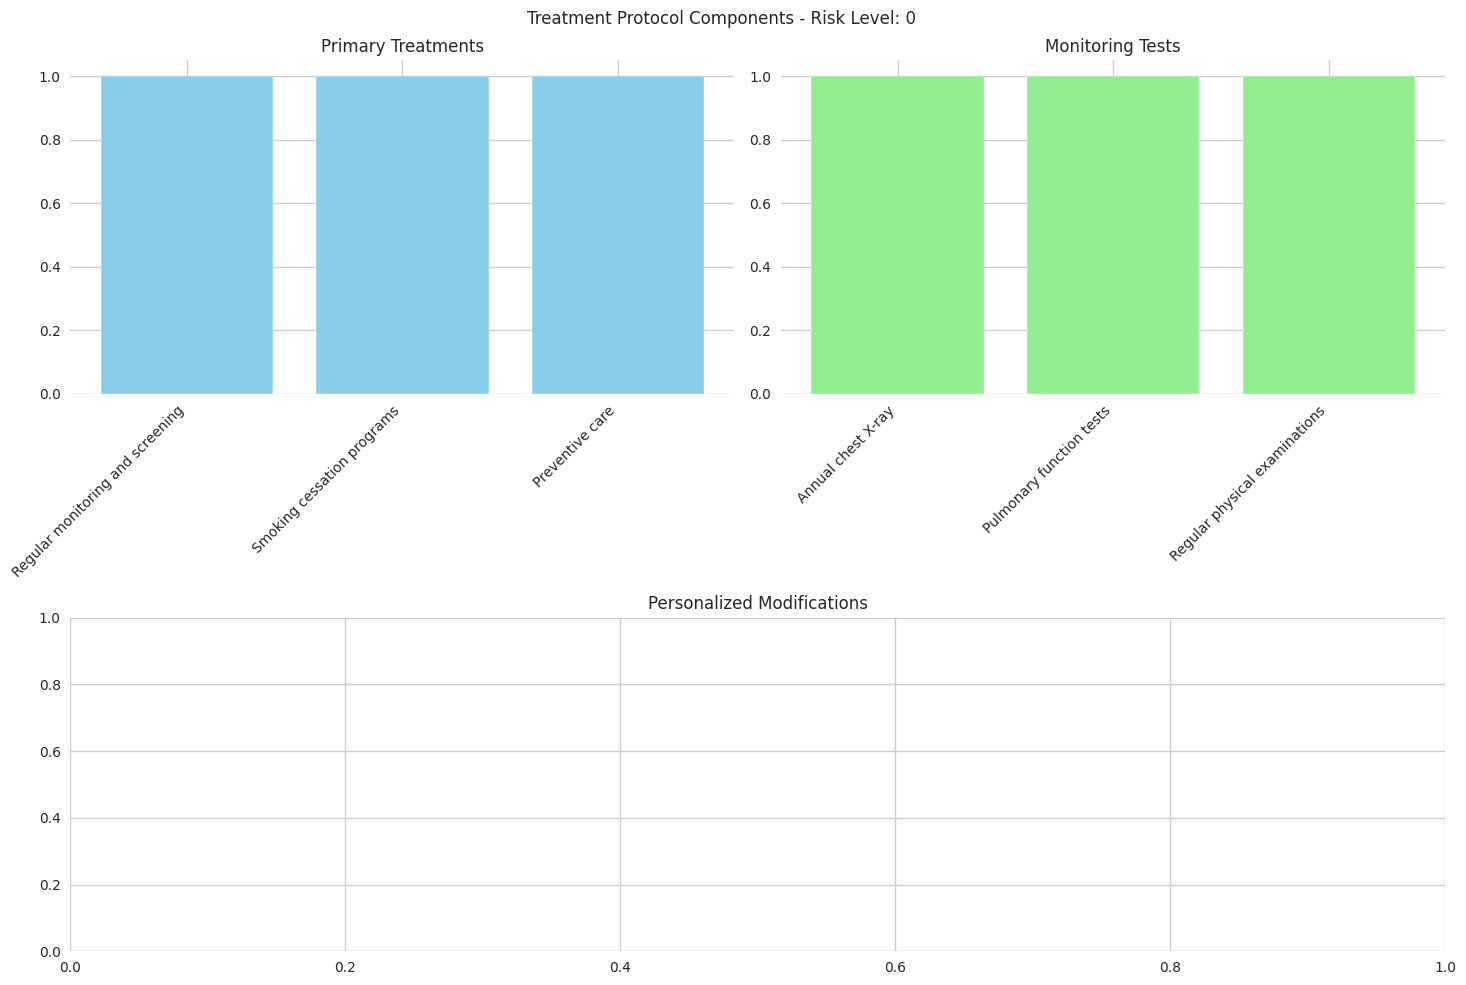


Treatment Protocol for 0 Risk Level

Primary Treatments:
1. Regular monitoring and screening
2. Smoking cessation programs
3. Preventive care

Screening Frequency: Every 6 months

Monitoring Tests:
1. Annual chest X-ray
2. Pulmonary function tests
3. Regular physical examinations

Lifestyle Recommendations:
1. Smoking cessation
2. Regular exercise
3. Healthy diet
4. Air quality monitoring


In [28]:
# Generate and display treatment protocol for sample patient
print("Generating personalized treatment protocol...")
protocol = determine_personalized_protocol(
    sample_patient,
    recommendations['risk_level'],
    recommendations['significant_deviations']
)

# Visualize protocol
visualize_treatment_protocol(protocol, recommendations['risk_level'])

# Print detailed protocol
print_treatment_protocol(protocol, recommendations['risk_level'])



In [29]:
# Add summary statistics
print("\nTreatment Protocol Summary Statistics:")
print("-"*50)
print(f"Total number of primary treatments: {len(protocol.get('primary_treatments', []))}")
print(f"Total number of monitoring tests: {len(protocol.get('monitoring_tests', []))}")
print(f"Number of personalized modifications: {len(protocol.get('personalized_modifications', []))}")


Treatment Protocol Summary Statistics:
--------------------------------------------------
Total number of primary treatments: 3
Total number of monitoring tests: 3
Number of personalized modifications: 0


# **Advanced Treatment Analysis System**

In [30]:
from scipy.stats import beta
import networkx as nx

def define_molecular_markers():
    """
    Define molecular markers and their associated treatment pathways.
    """
    return {
        'EGFR': {
            'treatments': ['Erlotinib', 'Gefitinib', 'Osimertinib'],
            'success_rate': 0.65,
            'testing_cost': 1200,
            'contraindications': ['severe liver disease'],
            'monitoring': ['Liver function tests', 'Regular CT scans']
        },
        'ALK': {
            'treatments': ['Alectinib', 'Crizotinib', 'Ceritinib'],
            'success_rate': 0.70,
            'testing_cost': 1500,
            'contraindications': ['severe heart conditions'],
            'monitoring': ['Cardiac monitoring', 'Vision tests']
        },
        'PD-L1': {
            'treatments': ['Pembrolizumab', 'Nivolumab', 'Atezolizumab'],
            'success_rate': 0.45,
            'testing_cost': 900,
            'contraindications': ['autoimmune diseases'],
            'monitoring': ['Thyroid function', 'Liver function']
        },
        'KRAS': {
            'treatments': ['Sotorasib', 'Standard chemotherapy'],
            'success_rate': 0.40,
            'testing_cost': 1000,
            'contraindications': ['kidney dysfunction'],
            'monitoring': ['Kidney function tests']
        }
    }

In [31]:
def define_drug_interactions():
    """
    Define known drug interactions and contraindications.
    """
    return {
        'Erlotinib': {
            'interactions': ['Ketoconazole', 'Rifampicin'],
            'severity': 'high',
            'alternative': 'Gefitinib'
        },
        'Gefitinib': {
            'interactions': ['Warfarin', 'Phenytoin'],
            'severity': 'moderate',
            'alternative': 'Erlotinib'
        },
        'Osimertinib': {
            'interactions': ['Carbamazepine', 'St. John\'s Wort'],
            'severity': 'high',
            'alternative': 'Gefitinib'
        },
        'Standard chemotherapy': {
            'interactions': ['Immunosuppressants', 'Blood thinners'],
            'severity': 'moderate',
            'alternative': 'Modified dosing schedule'
        }
    }


In [32]:
def define_treatment_costs():
    """
    Define cost structure for different treatments.
    """
    return {
        'Targeted Therapy': {
            'initial_testing': 2500,
            'monthly_cost': 8000,
            'duration_months': 12,
            'monitoring_cost': 500,
            'insurance_coverage': 0.80
        },
        'Immunotherapy': {
            'initial_testing': 1800,
            'monthly_cost': 12000,
            'duration_months': 24,
            'monitoring_cost': 600,
            'insurance_coverage': 0.75
        },
        'Chemotherapy': {
            'initial_testing': 1000,
            'monthly_cost': 5000,
            'duration_months': 6,
            'monitoring_cost': 400,
            'insurance_coverage': 0.85
        },
        'Surgery': {
            'procedure_cost': 35000,
            'hospital_stay': 5000,
            'follow_up': 2000,
            'insurance_coverage': 0.90
        }
    }

In [33]:
class TreatmentAnalyzer:
    def __init__(self):
        self.molecular_markers = define_molecular_markers()
        self.drug_interactions = define_drug_interactions()
        self.treatment_costs = define_treatment_costs()

    def analyze_molecular_markers(self, patient_markers):
        """
        Analyze patient's molecular markers and recommend treatments.
        """
        recommendations = []
        for marker, status in patient_markers.items():
            if status and marker in self.molecular_markers:
                marker_info = self.molecular_markers[marker]
                recommendations.append({
                    'marker': marker,
                    'treatments': marker_info['treatments'],
                    'success_rate': marker_info['success_rate'],
                    'monitoring': marker_info['monitoring']
                })
        return recommendations

    def check_drug_interactions(self, proposed_treatment, current_medications):
        """
        Check for potential drug interactions.
        """
        interactions = []
        if proposed_treatment in self.drug_interactions:
            drug_info = self.drug_interactions[proposed_treatment]
            for med in current_medications:
                if med in drug_info['interactions']:
                    interactions.append({
                        'medication': med,
                        'severity': drug_info['severity'],
                        'alternative': drug_info['alternative']
                    })
        return interactions

    def calculate_success_probability(self, treatment_type, patient_factors):
        """
        Calculate treatment success probability using Beta distribution.
        """
        base_rate = {
            'Targeted Therapy': (65, 35),  # 65% success rate
            'Immunotherapy': (45, 55),     # 45% success rate
            'Chemotherapy': (40, 60),      # 40% success rate
            'Surgery': (80, 20)            # 80% success rate
        }

        if treatment_type not in base_rate:
            return None

        # Adjust base rate based on patient factors
        a, b = base_rate[treatment_type]

        # Modify based on patient factors
        for factor, impact in patient_factors.items():
            if impact > 0:
                a *= (1 + impact)
            else:
                b *= (1 - impact)

        # Generate distribution
        x = np.linspace(0, 1, 100)
        dist = beta(a, b)

        return {
            'mean_probability': dist.mean(),
            'confidence_interval': (dist.ppf(0.025), dist.ppf(0.975)),
            'distribution': (x, dist.pdf(x))
        }

    def estimate_treatment_costs(self, treatment_plan, insurance_type='standard'):
        """
        Estimate total cost of treatment plan.
        """
        total_cost = 0
        cost_breakdown = {}

        for treatment_type, details in treatment_plan.items():
            if treatment_type in self.treatment_costs:
                cost_info = self.treatment_costs[treatment_type]

                if treatment_type == 'Surgery':
                    treatment_cost = (
                        cost_info['procedure_cost'] +
                        cost_info['hospital_stay'] +
                        cost_info['follow_up']
                    )
                else:
                    treatment_cost = (
                        cost_info['initial_testing'] +
                        (cost_info['monthly_cost'] * cost_info['duration_months']) +
                        (cost_info['monitoring_cost'] * cost_info['duration_months'])
                    )

                insurance_coverage = cost_info['insurance_coverage']
                if insurance_type == 'premium':
                    insurance_coverage += 0.10
                elif insurance_type == 'basic':
                    insurance_coverage -= 0.10

                out_of_pocket = treatment_cost * (1 - insurance_coverage)

                cost_breakdown[treatment_type] = {
                    'total_cost': treatment_cost,
                    'insurance_coverage': insurance_coverage * 100,
                    'out_of_pocket': out_of_pocket
                }

                total_cost += treatment_cost

        return {
            'total_cost': total_cost,
            'breakdown': cost_breakdown
        }

In [34]:
def visualize_treatment_analysis(analyzer, patient_data):
    """
    Create comprehensive visualizations for treatment analysis.
    """
    # Create figure with multiple subplots
    plt.figure(figsize=(20, 15))

    # 1. Success Probability Distribution
    plt.subplot(2, 2, 1)
    for treatment in ['Targeted Therapy', 'Immunotherapy', 'Chemotherapy']:
        prob = analyzer.calculate_success_probability(treatment, patient_data.get('factors', {}))
        if prob:
            plt.plot(prob['distribution'][0], prob['distribution'][1],
                    label=f"{treatment} (Mean: {prob['mean_probability']:.2%})")
    plt.title('Treatment Success Probability Distributions')
    plt.xlabel('Success Probability')
    plt.ylabel('Density')
    plt.legend()

    # 2. Cost Comparison
    plt.subplot(2, 2, 2)
    costs = analyzer.estimate_treatment_costs({'Targeted Therapy': {}, 'Immunotherapy': {}, 'Chemotherapy': {}})
    treatments = list(costs['breakdown'].keys())
    total_costs = [info['total_cost'] for info in costs['breakdown'].values()]
    out_of_pocket = [info['out_of_pocket'] for info in costs['breakdown'].values()]

    x = np.arange(len(treatments))
    width = 0.35
    plt.bar(x - width/2, total_costs, width, label='Total Cost')
    plt.bar(x + width/2, out_of_pocket, width, label='Out of Pocket')
    plt.xticks(x, treatments)
    plt.title('Treatment Cost Comparison')
    plt.ylabel('Cost ($)')
    plt.legend()

    # 3. Drug Interaction Network
    plt.subplot(2, 2, 3)
    G = nx.Graph()
    for drug, interactions in analyzer.drug_interactions.items():
        G.add_node(drug)
        for interaction in interactions['interactions']:
            G.add_node(interaction)
            G.add_edge(drug, interaction)
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue',
            node_size=2000, font_size=8)
    plt.title('Drug Interaction Network')

    # 4. Molecular Marker Success Rates
    plt.subplot(2, 2, 4)
    markers = list(analyzer.molecular_markers.keys())
    success_rates = [info['success_rate'] for info in analyzer.molecular_markers.values()]
    plt.bar(markers, success_rates)
    plt.title('Molecular Marker Treatment Success Rates')
    plt.ylabel('Success Rate')

    plt.tight_layout()
    plt.show()

Initializing Advanced Treatment Analysis...

Analyzing treatment options...

Molecular Marker Analysis:
--------------------------------------------------

Marker: EGFR
Recommended treatments: Erlotinib, Gefitinib, Osimertinib
Expected success rate: 65.0%
Required monitoring: Liver function tests, Regular CT scans

Marker: PD-L1
Recommended treatments: Pembrolizumab, Nivolumab, Atezolizumab
Expected success rate: 45.0%
Required monitoring: Thyroid function, Liver function

Checking drug interactions...

Interactions for Gefitinib:
- Interacts with Warfarin (Severity: moderate)
  Alternative: Erlotinib

Calculating success probabilities...

Targeted Therapy:
Mean success probability: 64.8%
95% confidence interval: (56.1%, 73.1%)

Immunotherapy:
Mean success probability: 44.8%
95% confidence interval: (36.1%, 53.7%)

Chemotherapy:
Mean success probability: 39.8%
95% confidence interval: (31.3%, 48.6%)

Estimating treatment costs...

Cost Analysis:
----------------------------------------

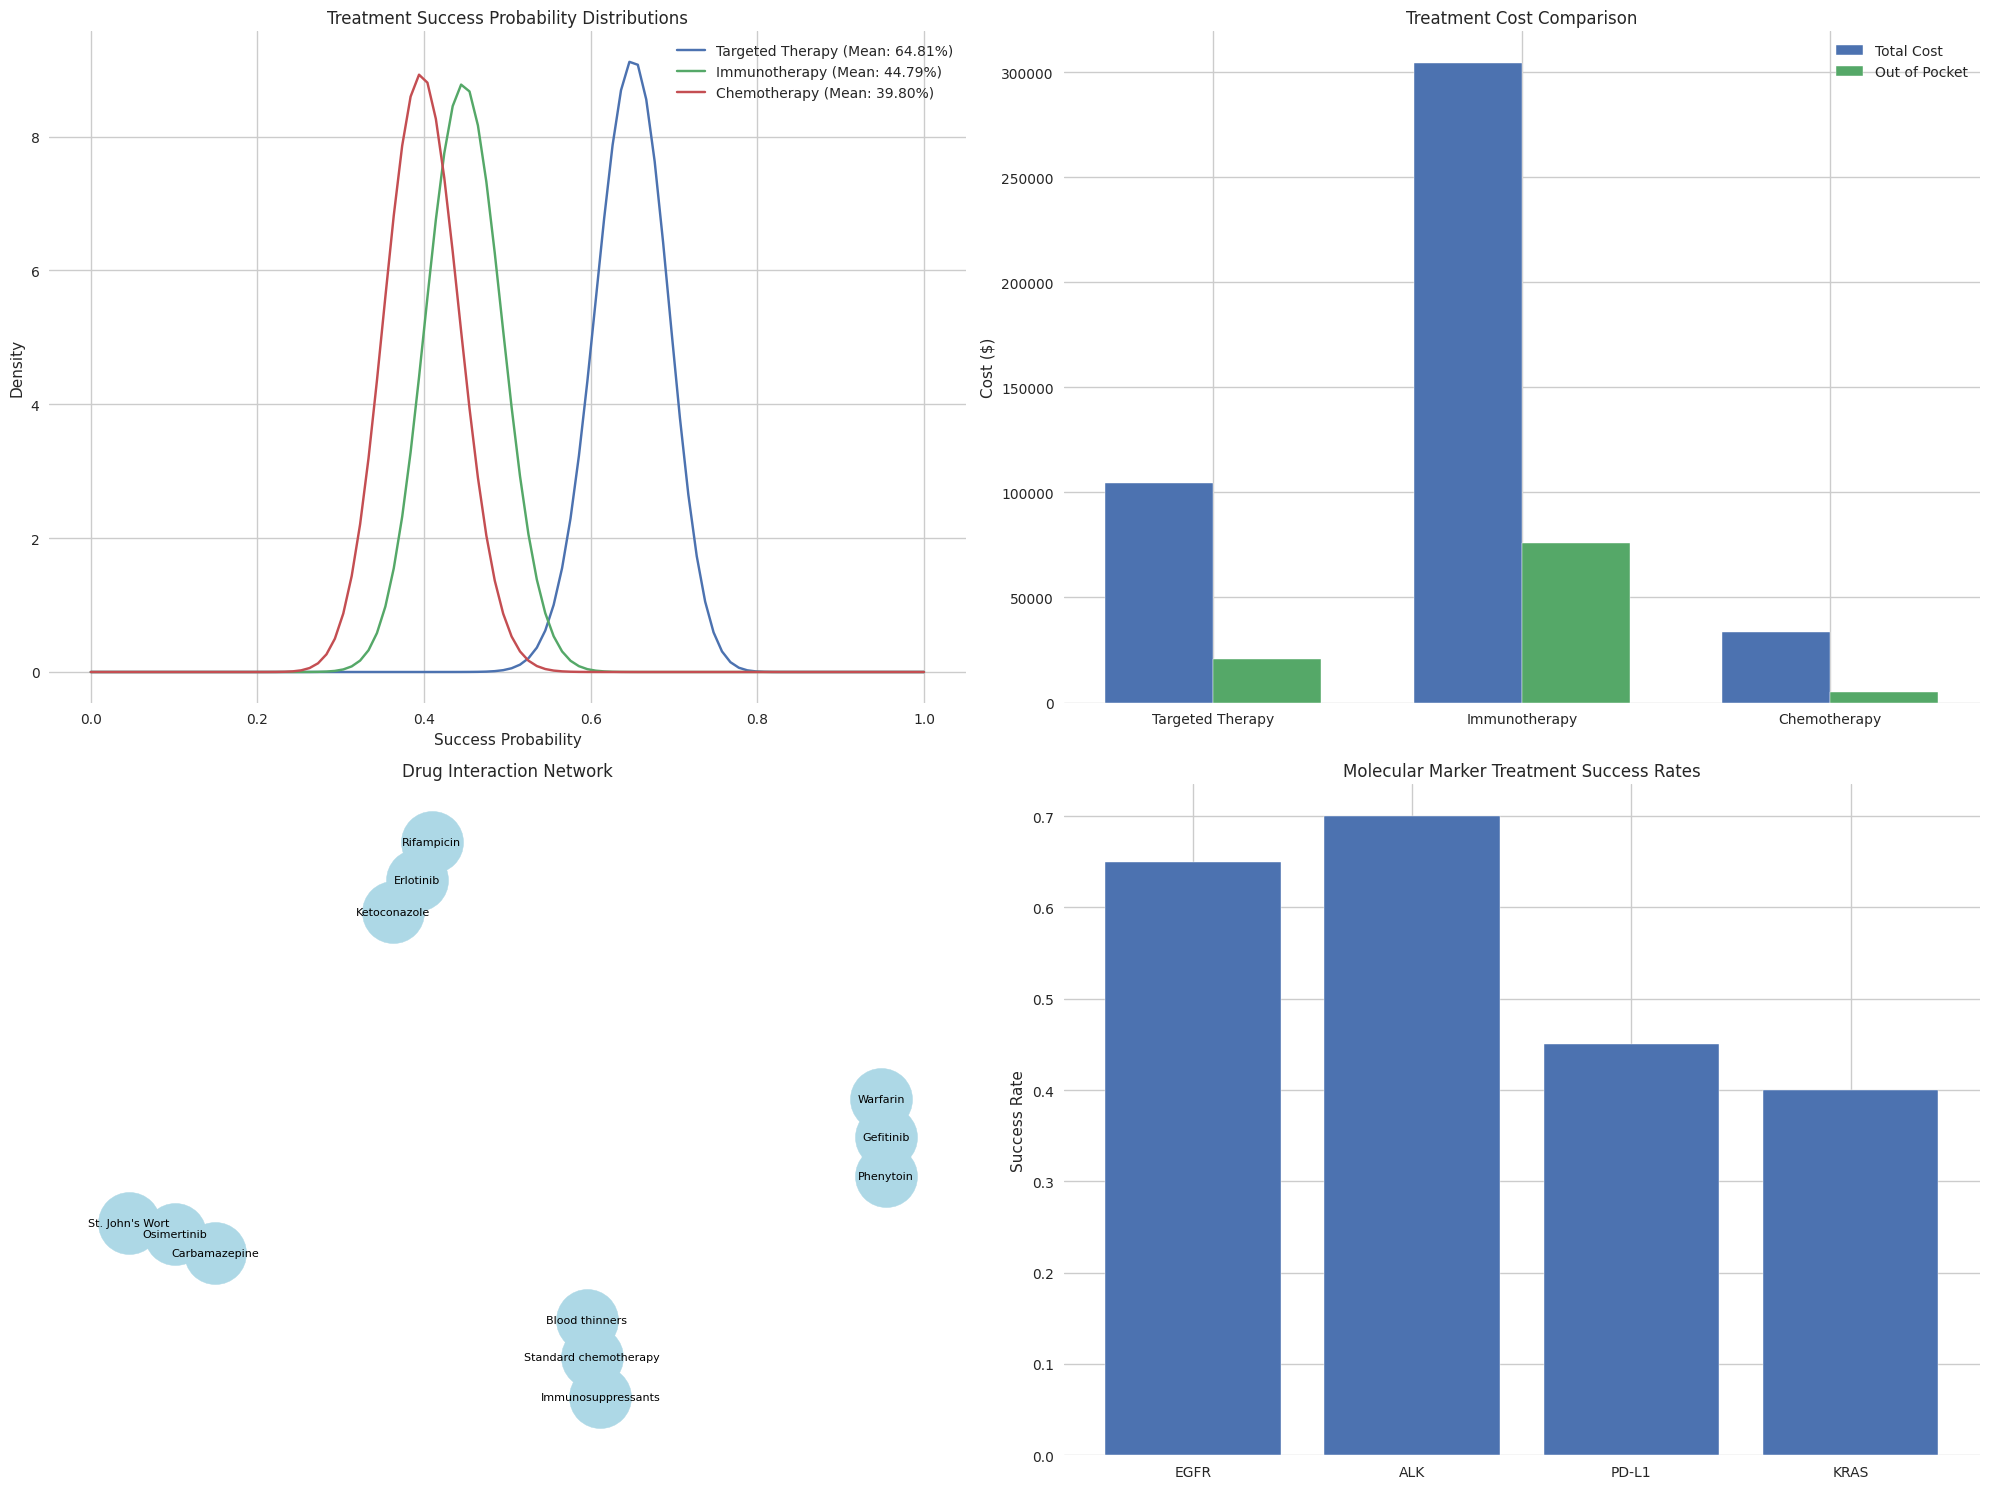

In [35]:
# Example usage
print("Initializing Advanced Treatment Analysis...")

# Create analyzer instance
analyzer = TreatmentAnalyzer()

# Example patient data
example_patient = {
    'molecular_markers': {
        'EGFR': True,
        'ALK': False,
        'PD-L1': True,
        'KRAS': False
    },
    'current_medications': ['Warfarin', 'Metformin'],
    'factors': {
        'age': -0.1,
        'general_health': 0.2,
        'tumor_size': -0.1
    },
    'insurance_type': 'standard'
}

# Perform analysis
print("\nAnalyzing treatment options...")
molecular_recommendations = analyzer.analyze_molecular_markers(example_patient['molecular_markers'])

print("\nMolecular Marker Analysis:")
print("-" * 50)
for rec in molecular_recommendations:
    print(f"\nMarker: {rec['marker']}")
    print(f"Recommended treatments: {', '.join(rec['treatments'])}")
    print(f"Expected success rate: {rec['success_rate']:.1%}")
    print(f"Required monitoring: {', '.join(rec['monitoring'])}")

print("\nChecking drug interactions...")
for treatment in molecular_recommendations[0]['treatments']:
    interactions = analyzer.check_drug_interactions(treatment, example_patient['current_medications'])
    if interactions:
        print(f"\nInteractions for {treatment}:")
        for interaction in interactions:
            print(f"- Interacts with {interaction['medication']} (Severity: {interaction['severity']})")
            print(f"  Alternative: {interaction['alternative']}")

print("\nCalculating success probabilities...")
treatment_types = ['Targeted Therapy', 'Immunotherapy', 'Chemotherapy']
for treatment in treatment_types:
    prob = analyzer.calculate_success_probability(treatment, example_patient['factors'])
    print(f"\n{treatment}:")
    print(f"Mean success probability: {prob['mean_probability']:.1%}")
    print(f"95% confidence interval: ({prob['confidence_interval'][0]:.1%}, {prob['confidence_interval'][1]:.1%})")

print("\nEstimating treatment costs...")
treatment_plan = {
    'Targeted Therapy': {},
    'Immunotherapy': {},
    'Chemotherapy': {}
}
costs = analyzer.estimate_treatment_costs(treatment_plan, example_patient['insurance_type'])
print("\nCost Analysis:")
print("-" * 50)
for treatment, details in costs['breakdown'].items():
    print(f"\n{treatment}:")
    print(f"Total cost: ${details['total_cost']:,.2f}")
    print(f"Insurance coverage: {details['insurance_coverage']:.1f}%")
    print(f"Out of pocket: ${details['out_of_pocket']:,.2f}")

# Visualize results
print("\nGenerating visualizations...")
visualize_treatment_analysis(analyzer, example_patient)

# **Treatment Timing and Quality of Life Analysis**

In [49]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm

class TreatmentOptimizer:
    def __init__(self):
        """Initialize treatment optimizer with QoL metrics and timing parameters."""
        self.qol_metrics = self._define_qol_metrics()
        self.treatment_timing = self._define_treatment_timing()
        self.recovery_patterns = self._define_recovery_patterns()

    def _define_qol_metrics(self):
        """Define quality of life metrics and their weights."""
        return {
            'physical': {
                'mobility': {'weight': 0.2, 'scale': (0, 10)},
                'pain': {'weight': 0.2, 'scale': (0, 10)},
                'fatigue': {'weight': 0.15, 'scale': (0, 10)},
                'sleep': {'weight': 0.1, 'scale': (0, 10)}
            },
            'emotional': {
                'anxiety': {'weight': 0.1, 'scale': (0, 10)},
                'depression': {'weight': 0.1, 'scale': (0, 10)},
                'social_isolation': {'weight': 0.08, 'scale': (0, 10)}
            },
            'functional': {
                'daily_activities': {'weight': 0.15, 'scale': (0, 10)},
                'work_capability': {'weight': 0.12, 'scale': (0, 10)}
            }
        }

    def _define_treatment_timing(self):
        """Define timing constraints and preferences for treatments."""
        return {
            'Surgery': {
                'duration': 1,  # days
                'recovery_time': 30,  # days
                'optimal_sequence': 1,
                'required_gap_before': 14,
                'required_gap_after': 21,
                'qol_impact': {
                    'immediate': -0.8,
                    'recovery_rate': 0.03,
                    'long_term': -0.1
                }
            },
            'Chemotherapy': {
                'duration': 21,  # days per cycle
                'cycles': 6,
                'optimal_sequence': 2,
                'required_gap_before': 21,
                'required_gap_after': 14,
                'qol_impact': {
                    'immediate': -0.6,
                    'recovery_rate': 0.02,
                    'long_term': -0.2
                }
            },
            'Radiation': {
                'duration': 35,  # days
                'optimal_sequence': 3,
                'required_gap_before': 14,
                'required_gap_after': 14,
                'qol_impact': {
                    'immediate': -0.5,
                    'recovery_rate': 0.025,
                    'long_term': -0.15
                }
            },
            'Immunotherapy': {
                'duration': 14,  # days per cycle
                'cycles': 12,
                'optimal_sequence': 4,
                'required_gap_before': 21,
                'required_gap_after': 21,
                'qol_impact': {
                    'immediate': -0.3,
                    'recovery_rate': 0.04,
                    'long_term': -0.05
                }
            }
        }

    def _define_recovery_patterns(self):
        """Define recovery patterns and their impact on QoL."""
        return {
            'rapid': {
                'description': 'Quick initial recovery with steady improvement',
                'function': lambda t: 1 - np.exp(-0.1 * t)
            },
            'gradual': {
                'description': 'Steady, linear improvement over time',
                #'function': lambda t: min(1, 0.05 * t)
                'function': lambda t: np.minimum(1, 0.05 * t)
            },
            'delayed': {
                'description': 'Slow initial recovery with later acceleration',
                'function': lambda t: 1 - 1/(1 + 0.05 * t)
            }
        }

    def optimize_treatment_timing(self, treatments, patient_factors, start_date=None):
        """
        Optimize treatment timing based on various factors.

        Parameters:
        treatments: list of planned treatments
        patient_factors: dict of patient-specific factors
        start_date: optional starting date
        """
        if start_date is None:
            start_date = datetime.now()

        # Initialize schedule
        schedule = []
        current_date = start_date
        total_duration = 0

        # Sort treatments by optimal sequence
        sorted_treatments = sorted(treatments,
                                 key=lambda x: self.treatment_timing[x]['optimal_sequence'])

        for treatment in sorted_treatments:
            timing = self.treatment_timing[treatment]

            # Calculate optimal gap based on patient factors
            optimal_gap = timing['required_gap_before']
            if patient_factors.get('age', 0) > 70:
                optimal_gap *= 1.2
            if patient_factors.get('general_health', 5) < 3:
                optimal_gap *= 1.3

            # Add gap if not first treatment
            if schedule:
                current_date += timedelta(days=int(optimal_gap))

            # Calculate treatment duration
            duration = timing['duration']
            if 'cycles' in timing:
                duration *= timing['cycles']

            schedule.append({
                'treatment': treatment,
                'start_date': current_date,
                'end_date': current_date + timedelta(days=duration),
                'duration': duration,
                'required_gap_after': timing['required_gap_after']
            })

            current_date += timedelta(days=duration)
            total_duration += duration

        return schedule, total_duration

    def calculate_qol_impact(self, schedule, patient_factors, duration_days):
        """Calculate quality of life impact over time."""
        timeline = np.arange(duration_days)
        qol_scores = np.ones(duration_days)  # Start with perfect QoL

        for treatment in schedule:
            start_idx = (treatment['start_date'] - schedule[0]['start_date']).days
            end_idx = start_idx + treatment['duration']

            timing_info = self.treatment_timing[treatment['treatment']]

            # Calculate immediate impact
            impact = timing_info['qol_impact']['immediate']
            if patient_factors.get('resilience', 5) > 7:
                impact *= 0.8
            elif patient_factors.get('resilience', 5) < 3:
                impact *= 1.2

            # Apply impact and recovery pattern
            treatment_period = np.arange(treatment['duration'])
            #recovery_pattern = self.recovery_patterns['gradual']['function'](treatment_period)
            recovery_pattern = np.minimum(1, 0.05 * treatment_period)

            qol_impact = impact * (1 - recovery_pattern)
            #qol_scores[start_idx:end_idx] += qol_impact
            # Pad qol_impact with zeros if it's shorter than the slice of qol_scores
            slice_len = min(end_idx, len(qol_scores)) - start_idx


            if len(qol_impact) < slice_len:
                qol_impact = np.pad(qol_impact, (0, slice_len - len(qol_impact)), 'constant', constant_values=0)
            else:
                qol_impact = qol_impact[:slice_len] # Truncate if it is longer

            qol_scores[start_idx : start_idx + slice_len] += qol_impact


            # Apply long-term impact
            if end_idx < len(qol_scores):
                qol_scores[end_idx:] += timing_info['qol_impact']['long_term']

        return np.clip(qol_scores, 0, 1)  # Ensure scores are between 0 and 1

    def analyze_qol_components(self, baseline_qol, treatment_schedule):
        """Analyze individual QoL components over time."""
        component_scores = {}

        for category, metrics in self.qol_metrics.items():
            category_scores = {}
            for metric, details in metrics.items():
                baseline = baseline_qol.get(f"{category}_{metric}", details['scale'][1] / 2)
                scores = []

                for treatment in treatment_schedule:
                    timing_info = self.treatment_timing[treatment['treatment']]
                    impact = timing_info['qol_impact']['immediate'] * details['weight']
                    recovery_rate = timing_info['qol_impact']['recovery_rate']

                    treatment_scores = [
                        baseline * (1 + impact * np.exp(-recovery_rate * t))
                        for t in range(treatment['duration'])
                    ]
                    scores.extend(treatment_scores)

                category_scores[metric] = np.clip(scores,
                                                details['scale'][0],
                                                details['scale'][1])

            component_scores[category] = category_scores

        return component_scores


In [50]:
def visualize_treatment_timeline(optimizer, schedule, qol_scores):
    """Visualize treatment timeline and QoL impact."""
    fig = plt.figure(figsize=(20, 12))
    gs = plt.GridSpec(3, 1, height_ratios=[2, 1, 1])

    # Treatment Timeline
    ax1 = fig.add_subplot(gs[0])
    colors = plt.cm.Set3(np.linspace(0, 1, len(schedule)))

    for i, treatment in enumerate(schedule):
        start_date = treatment['start_date']
        duration = treatment['duration']

        ax1.barh(y=0, width=duration, left=(start_date - schedule[0]['start_date']).days,
                color=colors[i], label=treatment['treatment'])

    ax1.set_title('Treatment Timeline')
    ax1.set_xlabel('Days from Start')
    ax1.set_yticks([])
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # QoL Score Timeline
    ax2 = fig.add_subplot(gs[1])
    ax2.plot(qol_scores, 'b-', label='Overall QoL')
    ax2.set_title('Quality of Life Score Over Time')
    ax2.set_xlabel('Days from Start')
    ax2.set_ylabel('QoL Score')
    ax2.grid(True)
    ax2.legend()

    # Recovery Patterns
    ax3 = fig.add_subplot(gs[2])
    t = np.linspace(0, 100, 100)
    for pattern_name, pattern in optimizer.recovery_patterns.items():
        ax3.plot(t, pattern['function'](t), label=pattern_name)

    ax3.set_title('Recovery Patterns')
    ax3.set_xlabel('Days')
    ax3.set_ylabel('Recovery Progress')
    ax3.grid(True)
    ax3.legend()

    plt.tight_layout()
    plt.show()

Initializing Treatment Optimization System...

Optimizing treatment schedule...

Calculating quality of life impact...

Analyzing QoL components...

Optimized Treatment Schedule:
--------------------------------------------------

Surgery:
Start Date: 2024-11-01
End Date: 2024-11-02
Duration: 1 days
Required Gap After: 21 days

Chemotherapy:
Start Date: 2024-11-23
End Date: 2025-03-29
Duration: 126 days
Required Gap After: 14 days

Radiation:
Start Date: 2025-04-12
End Date: 2025-05-17
Duration: 35 days
Required Gap After: 14 days

Immunotherapy:
Start Date: 2025-06-07
End Date: 2025-11-22
Duration: 168 days
Required Gap After: 21 days

Quality of Life Analysis:
--------------------------------------------------
Average QoL Score: 0.68
Minimum QoL Score: 0.20
Maximum QoL Score: 0.90

Generating visualizations...


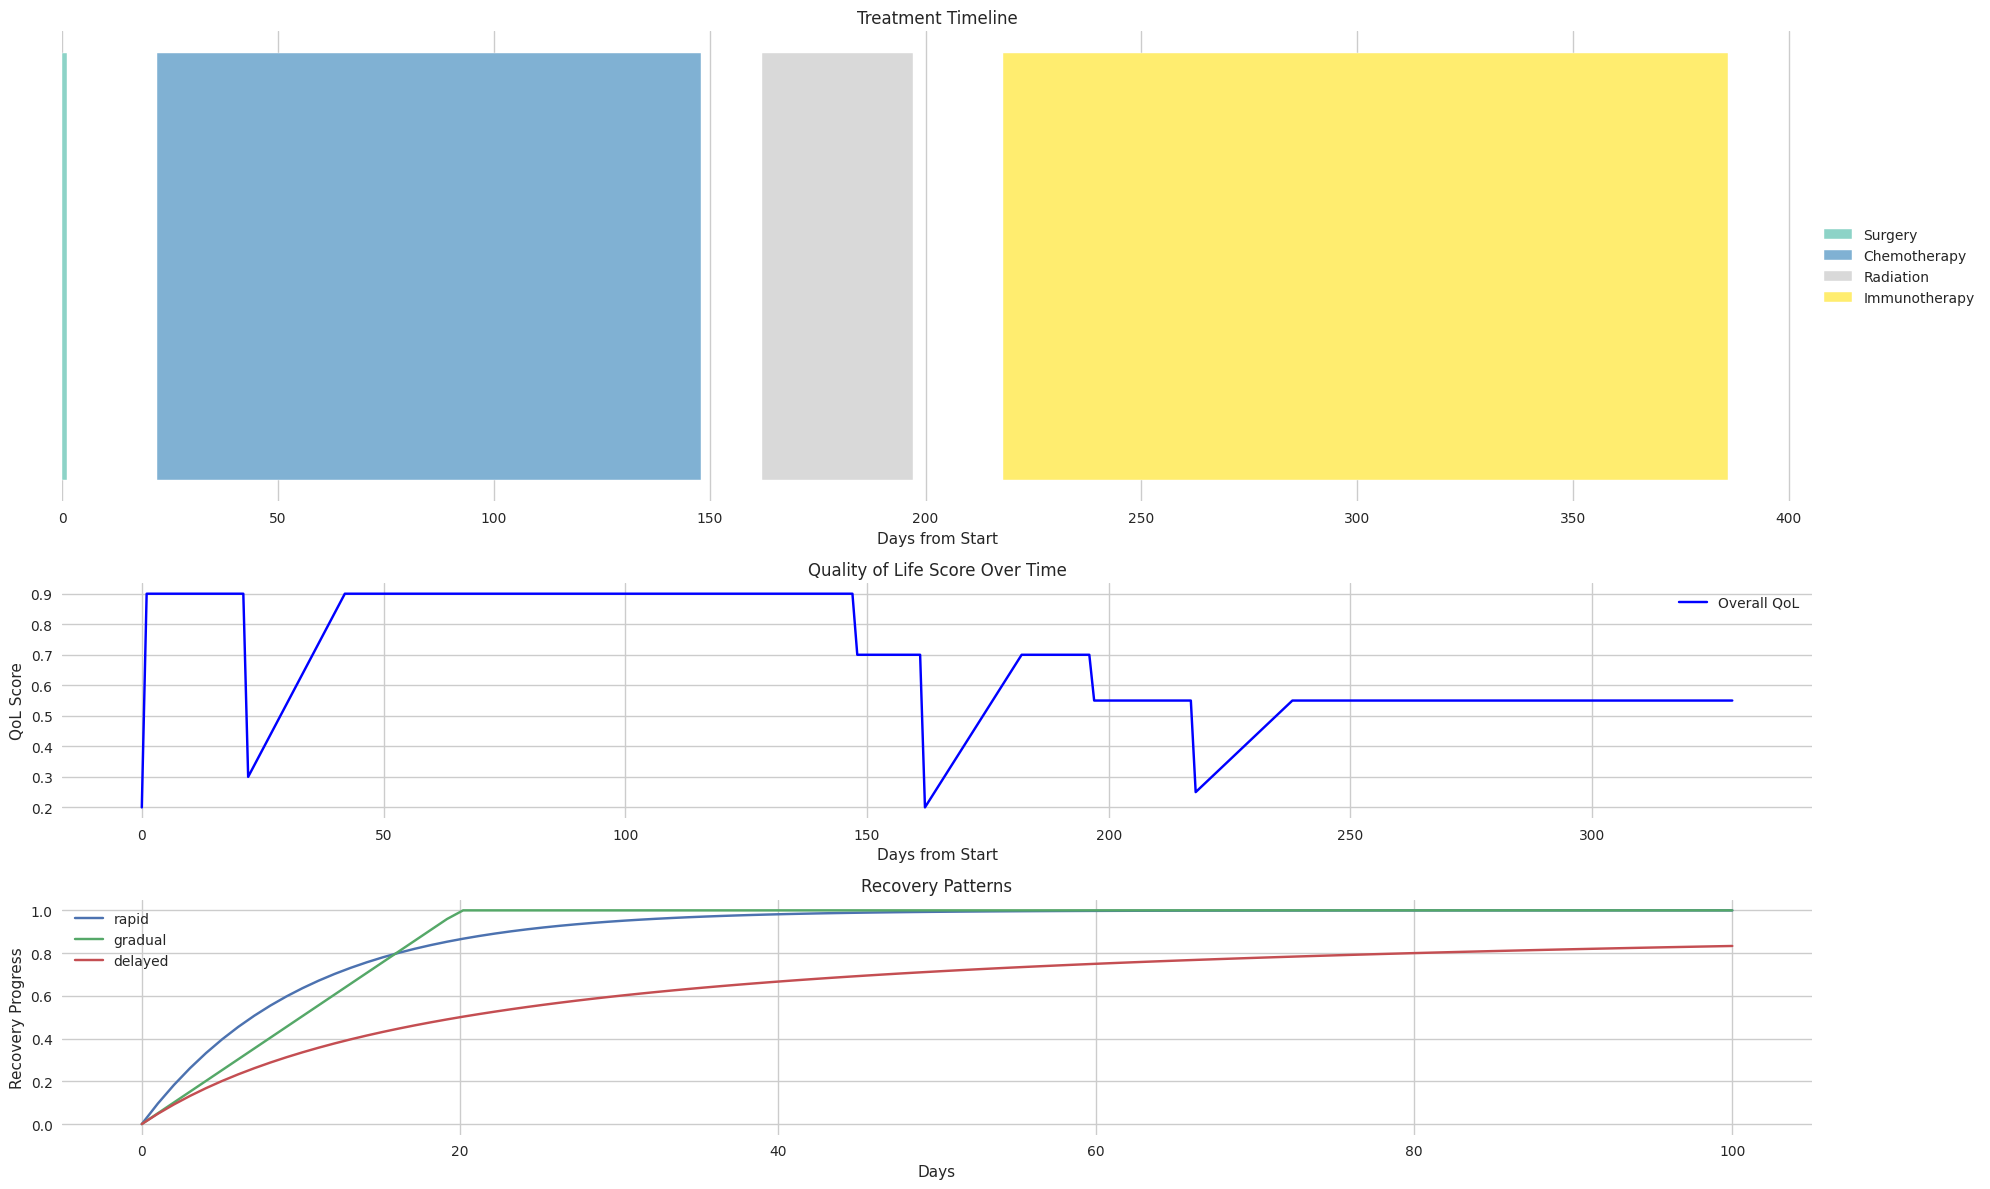

In [51]:
# Example usage
print("Initializing Treatment Optimization System...")

# Create optimizer instance
optimizer = TreatmentOptimizer()

# Example patient data
patient_factors = {
    'age': 65,
    'general_health': 7,
    'resilience': 6,
    'support_system': 8
}

# Example baseline QoL
baseline_qol = {
    'physical_mobility': 8,
    'physical_pain': 7,
    'physical_fatigue': 8,
    'emotional_anxiety': 6,
    'functional_daily_activities': 7
}

# Define treatments
treatments = ['Surgery', 'Chemotherapy', 'Radiation', 'Immunotherapy']

# Optimize treatment timing
print("\nOptimizing treatment schedule...")
schedule, total_duration = optimizer.optimize_treatment_timing(
    treatments,
    patient_factors,
    start_date=datetime.now()
)

# Calculate QoL impact
print("\nCalculating quality of life impact...")
qol_scores = optimizer.calculate_qol_impact(schedule, patient_factors, total_duration)

# Analyze QoL components
print("\nAnalyzing QoL components...")
qol_components = optimizer.analyze_qol_components(baseline_qol, schedule)

# Print optimized schedule
print("\nOptimized Treatment Schedule:")
print("-" * 50)
for treatment in schedule:
    print(f"\n{treatment['treatment']}:")
    print(f"Start Date: {treatment['start_date'].strftime('%Y-%m-%d')}")
    print(f"End Date: {treatment['end_date'].strftime('%Y-%m-%d')}")
    print(f"Duration: {treatment['duration']} days")
    print(f"Required Gap After: {treatment['required_gap_after']} days")

# Print QoL analysis
print("\nQuality of Life Analysis:")
print("-" * 50)
print(f"Average QoL Score: {np.mean(qol_scores):.2f}")
print(f"Minimum QoL Score: {np.min(qol_scores):.2f}")
print(f"Maximum QoL Score: {np.max(qol_scores):.2f}")

# Generate visualizations
print("\nGenerating visualizations...")
visualize_treatment_timeline(optimizer, schedule, qol_scores)



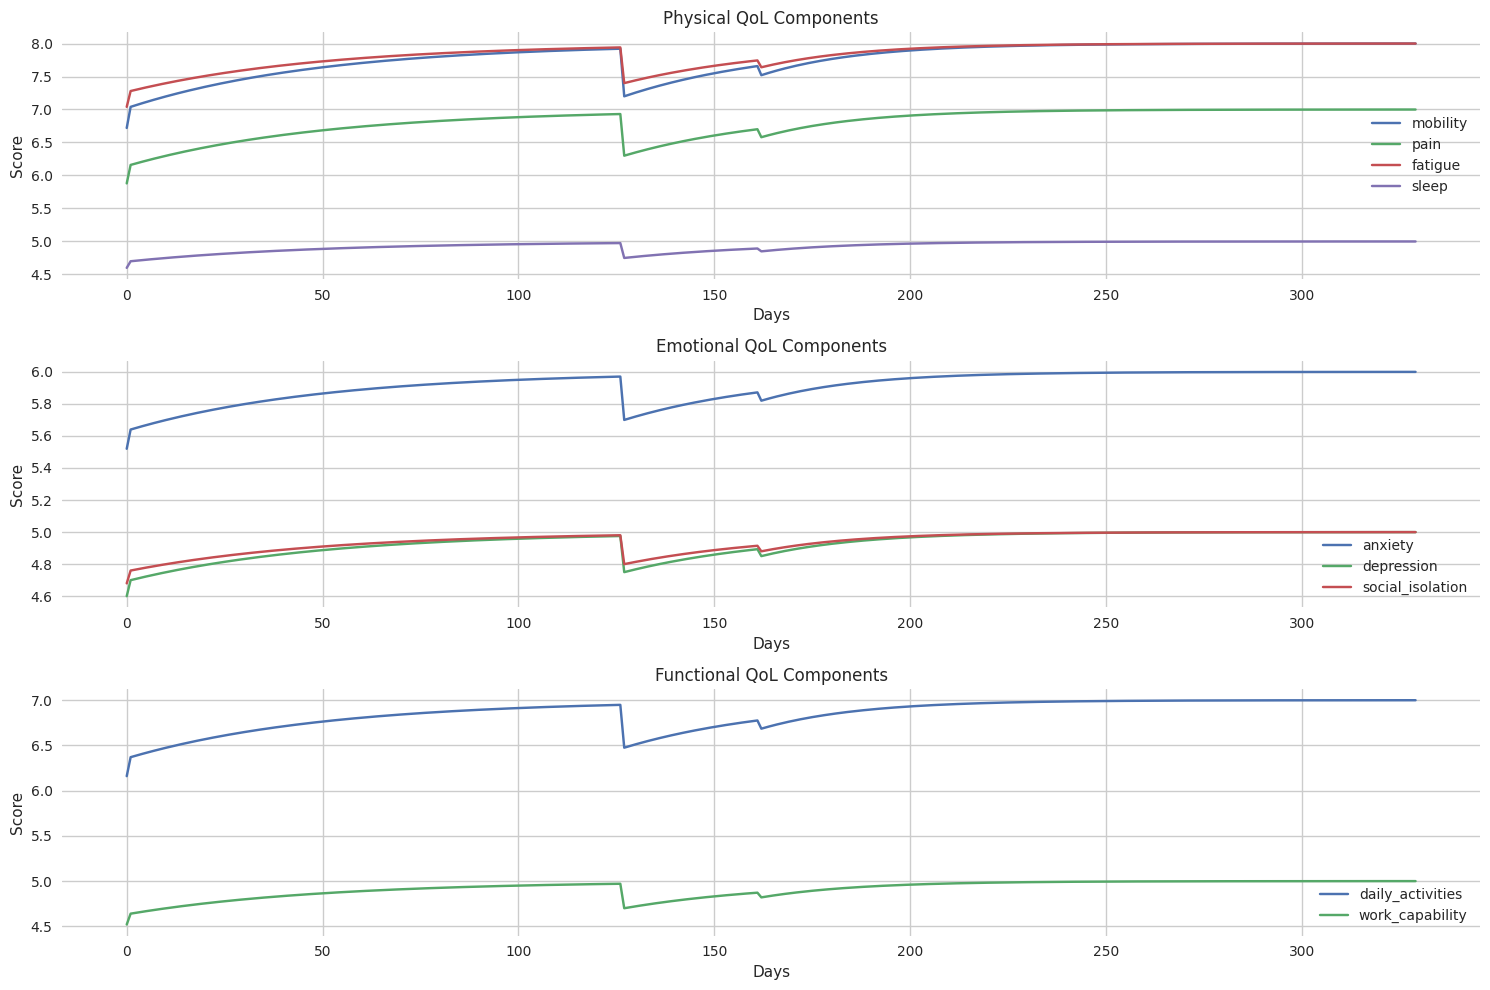

In [52]:
# Additional QoL component visualization
plt.figure(figsize=(15, 10))
for i, (category, metrics) in enumerate(qol_components.items(), 1):
    plt.subplot(3, 1, i)
    for metric, scores in metrics.items():
        plt.plot(scores, label=metric)
    plt.title(f'{category.capitalize()} QoL Components')
    plt.xlabel('Days')
    plt.ylabel('Score')
    plt.grid(True)
    plt.legend()
plt.tight_layout()
plt.show()